# Overview
**DayCent regional simulation results post-processing**

This Jupyter Notebook is designed to facilitate post-processing and analysis of sets of raw DayCent results from a regional scale simulation. For more information, contact author [John Field](https://johnlfield.weebly.com/) at <john.L.field@gmail.com>

## DayCent background

DayCent is a process-based model that simulates agro-ecosystem net primary production, soil organic matter dynamics, and nitrogen (N) cycling and trace gas emissions. DayCent is a daily-timestep version of the older CENTURY model. Both models were created and are currently maintained at the Colorado State University [Natural Resource Ecology Laboratory](https://www.nrel.colostate.edu/) (CSU-NREL), and source code is available upon request.  DayCent model homepage:  [https://www2.nrel.colostate.edu/projects/daycent/](https://www2.nrel.colostate.edu/projects/daycent/)

## Regional workflow

The primary spatial data inputs to DayCent are:
* soil texture as a function of depth
* historic daily weather (Tmin, Tmax, precip)

Our DayCent spatial modeling workflow is based on a national-scale GIS database of current land use ([NLCD](https://www.mrlc.gov/national-land-cover-database-nlcd-2016)), soil ([SSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627)), and weather ([NARR](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr)) data layers housed at CSU-NREL. The python-based workflow consists of a collection of scripts that perform the following:
1. Selection of area to be simulated, specified based on current land cover and/or land biophysical factors (i.e., soil texutre, slope, land capability class rating, etc.)
2. Determination of individual unique DayCent model runs (i.e., **"strata"**) necessary to cover the heterogenity of soils and climate across the simulation area
3. Parallel execution of simulations on the CSU-NREL computing cluster
4. Results analysis and mapping (this routine)

# Code & data imports

## Load python modules

In [1]:
import constants as con
from IPython.display import Image, display
import json
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import sys
from urllib.request import urlopen

## Load runtable

Individual DayCent strata are specified via a .csv format "runtable" file, which contains the following information:
* unique identifier (strata_no)
* ID for DayCent spin-up archive (runno)
* SSURGO soil map unit ID (mukey_int)
* NARR climate grid ID (gridx & gridy)
* county FIPS code (fips)
* DayCent-format schedule file to simulate (sch_file)
* latitude of the county centroid, used to set perennial grass phenology (latitude)
* for simulations on abandoned agricultural land, year of peak ag land extent (peak_year)
* land area represented by that strata (tot_ha)
The code below loads the relevant runtable to a Pandas dataframe.

In [2]:
runtable = "ContUS_runtable_incl81.csv"
run_df = pd.read_csv(runtable, skiprows=[1])   # skip SQL datatype row
run_df

strata_no    runno  mukey_int  gridx  gridy   fips  \
0               1     8942     328058     89    234   1001   
1               2    17925     328059     89    234   1001   
2               3    27012     328060     89    234   1001   
3               4    36132     328061     89    234   1001   
4               5    45302     328062     89    234   1001   
...           ...      ...        ...    ...    ...    ...   
511039     568862  4490928    2516980    122    181  56045   
511040     568863  4490985    2516988    122    181  56045   
511041     568864  4490997    2516989    122    181  56045   
511042     568865  4491000    2516990    122    181  56045   
511043     568866  4491064    2517214    122    181  56045   

                      sch_file   latitude  peak_year      tot_ha  
0       idle_switchgrass75.sch  32.534931       1950  165.751842  
1       idle_switchgrass75.sch  32.534931       1950   17.960497  
2       idle_switchgrass75.sch  32.534931       1950  235.329205  
3       idle_switchgrass75.sch  32.534931       1950    2.221341  
4       idle_switchgrass75.sch  32.534931       1950   63.330603  
...                        ...        ...        ...         ...  
511039  idle_switchgrass75.sch  43.840485       2000    1.026365  
511040  idle_switchgrass75.sch  43.840485       2000    5.069576  
511041  idle_switchgrass75.sch  43.840485       2000   57.401776  
511042  idle_switchgrass75.sch  43.840485       2000   25.088445  
511043  idle_switchgrass75.sch  43.840485       2000   63.694119  

[511044 rows x 10 columns]

## Load DayCent results

Raw DayCent model output is spread across two files:
* .lis files contain information related to per-area biomass harvest and soil carbon
* year_summary.out contains per-area trace gas emissions

Reading these DayCent results data directly from the NREL network via Pulse Secure is ideal for avoiding clutter on my local machine. However, that is only practical for smaller datasets; multi-GB data takes hours to load. I had also tried to develop code in this notebook to sub-set the large DayCent raw results files on the NREL network (see code_scraps.py), to minimize the volume of data being read over the network or downloaded locally. However, it seems that reading network data over Pulse Secure is the bottle-neck (not necessarily loading it into a large Pandas DataFrame), so running that sub-setting routine from this notebook on my own machine was similarly slow.

I eventually found it quicker & more flexible to download the big raw data files locally via a shell Secure Copy command (with CSU Pulse Secure disabled), and process via a more normal linear workflow. The scp step takes approximately 2 min per GB. After that, reading the full local dataset to memory is reasonable (~2 min), and merging & filtering steps are quick enough (usually ~1 min each) that there is no need to change my workflow (designed more for code length & clarity than memory management). Here's an example shell Secure Copy command, for reference:
```console
scp jlf@trailridge.nrel.colostate.edu:/data/paustian/AFRI/simulations/results/2019-11-01,00.37__eastern_US_runtable_incl81__90__drought_sensitivity/year_summary.out /Users/johnfield/Desktop/2019-11-01,00.37__eastern_US_runtable_incl81__90__drought_sensitivity_year_summary.out
 ```

In [3]:
# specify simulation names for both baseline & drought tolerance results

base_sims = '2021-09-13,23.00__ContUS_runtable_incl81__79__ABM_ContUS'
# drought_sims = '2021-04-12,16.31__eastern_US_runtable_incl81__90__Drought_tol'

In [4]:
# # inspect head of raw data files over Pulse Secure 

# results_path = '/Volumes/wcnr-network/Research/Paustian/AFRI/simulations/results/'
# base_fpath = os.path.join(results_path, base_sims, 'X.lis')
# drought_fpath = os.path.join(results_path, drought_sims, 'X.lis')

# # base python equivalent to a bash 'head' command
# with open(base_fpath) as myfile:
#     head = [next(myfile) for x in range(90)]
#     for row in head:
#         print(row, end='')

# # with open(drought_fpath) as myfile:
# #     head = [next(myfile) for x in range(5)]
# # print(head)

First, we load and concatenate the .lis output for the relevant switchgrass variety scenarios. 

In [5]:
%%time

results_path = '/Users/53f/Desktop/Local_datasets/'

# to save time & memory, only upload the specific data columns that will be used in subsequent analysis
lis_cols = ['strata_no', 'time', 'crmvst', 'strmac(2)', 'volpac', 'd_somsc']

# .lis data import, skipping SQL datatype rows
base_lis_fpath = os.path.join(results_path, base_sims+'/X.lis')
base_lis_df = pd.read_csv(base_lis_fpath, skiprows=[1], usecols=lis_cols)
base_lis_df['variety'] = 'base'

# drought_lis_fpath = os.path.join(results_path, drought_sims+'/X.lis')
# drought_lis_df = pd.read_csv(drought_lis_fpath, skiprows=[1])
# drought_lis_df['variety'] = 'drought_tol'

# # concatenate scenario results
# lis_df = pd.concat([base_lis_df, drought_lis_df], axis=0)

lis_df = base_lis_df

CPU times: user 30.2 s, sys: 6.82 s, total: 37 s
Wall time: 40.3 s


Note that my DayCent workflow (or the underlying DayCent model) has an indexing issue with the .lis output. In this output, year 2022 is a dummy row, and the real 2022 results show up in the 2023 row, with all subsequent results frame-shifted accordingly. Thus, we have to drop the 2022 row, and shift the time index in all subsequent rows:

In [6]:
lis_df = lis_df[lis_df.time != 2021]
lis_df['time'] = np.where(lis_df['time'] > 2021, lis_df['time'] - 1, lis_df['time'])
# with pd.option_context('display.max_rows', 200):
#     display(lis_df[(lis_df.strata_no == 1) & (lis_df.variety == 'base')])
lis_df

<ipython-input-6-596bb2c681dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lis_df['time'] = np.where(lis_df['time'] > 2021, lis_df['time'] - 1, lis_df['time'])


strata_no  time   crmvst  strmac(2)  volpac  d_somsc variety
0                 1  1975    0.000      0.000   0.000    0.000    base
1                 1  1976    0.000      1.791   1.053   24.276    base
2                 1  1977    0.000      0.395   0.587   38.979    base
3                 1  1978    0.000      0.201   0.627   46.176    base
4                 1  1979    0.000      0.374   0.693   70.583    base
...             ...   ...      ...        ...     ...      ...     ...
46303865     568820  2067  462.695      8.813   0.580   -0.940    base
46303866     568820  2068  443.245     12.145   0.561   15.622    base
46303867     568820  2069  537.026      0.000   0.666   11.894    base
46303868     568820  2070  577.326      7.920   0.703    8.742    base
46303869     568820  2071  301.719      4.701   0.400   18.418    base

[45792826 rows x 7 columns]

Then, we do the same for the year_summary.out results.

In [7]:
%%time

ys_cols = ['strata_no', 'time', 'N2Oflux', 'NOflux', 'CH4', 'ANNPPT']

# year_summary.out data import, skipping SQL datatype rows
base_ys_fpath = os.path.join(results_path, base_sims+'/year_summary.out')
base_ys_df = pd.read_csv(base_ys_fpath, skiprows=[1], usecols=ys_cols)
base_ys_df['variety'] = 'base'

# drought_ys_fpath = os.path.join(results_path, drought_sims+'/year_summary.out')
# drought_ys_df = pd.read_csv(drought_ys_fpath, skiprows=[1])
# drought_ys_df['variety'] = 'drought_tol'

# # concatenate scenario results
# ys_df = pd.concat([base_ys_df, drought_ys_df], axis=0)

ys_df = base_ys_df
ys_df

CPU times: user 20.4 s, sys: 7.01 s, total: 27.4 s
Wall time: 31.7 s


strata_no  time   N2Oflux    NOflux       CH4      ANNPPT variety
0                 1  1975  0.071433  0.054203  0.221034  155.116943    base
1                 1  1976  0.013492  0.030303  0.247949  127.418991    base
2                 1  1977  0.020945  0.032218  0.246919  118.088013    base
3                 1  1978  0.022181  0.041216  0.216468  144.686279    base
4                 1  1979  0.020329  0.039546  0.214066  173.853271    base
...             ...   ...       ...       ...       ...         ...     ...
45792821     568820  2067  0.171823  0.088472  0.202949   57.304409    base
45792822     568820  2068  0.199013  0.081792  0.207332   63.666538    base
45792823     568820  2069  0.115536  0.112198  0.220917   59.125423    base
45792824     568820  2070  0.161654  0.104471  0.189069   77.159653    base
45792825     568820  2071  0.148002  0.083664  0.182980   57.734756    base

[45792826 rows x 7 columns]

In [8]:
# note that these abandoned land simulations begin in different years in different counties

lis_df.time.value_counts().sort_index()

1975    245314
1976    245314
1977    245314
1978    275336
1979    275336
         ...  
2067    511044
2068    511044
2069    511044
2070    511044
2071    511044
Name: time, Length: 97, dtype: int64

# Analysis

## Merge .lis & .out data

In [9]:
%%time

# merge .lis & year_summary.out DataFrames
df = pd.merge(lis_df, ys_df, on=['strata_no', 'variety', 'time'], validate='1:1')
df

CPU times: user 39.2 s, sys: 22.7 s, total: 1min 1s
Wall time: 1min 14s


strata_no  time   crmvst  strmac(2)  volpac  d_somsc variety  \
0                 1  1975    0.000      0.000   0.000    0.000    base   
1                 1  1976    0.000      1.791   1.053   24.276    base   
2                 1  1977    0.000      0.395   0.587   38.979    base   
3                 1  1978    0.000      0.201   0.627   46.176    base   
4                 1  1979    0.000      0.374   0.693   70.583    base   
...             ...   ...      ...        ...     ...      ...     ...   
45792821     568820  2067  462.695      8.813   0.580   -0.940    base   
45792822     568820  2068  443.245     12.145   0.561   15.622    base   
45792823     568820  2069  537.026      0.000   0.666   11.894    base   
45792824     568820  2070  577.326      7.920   0.703    8.742    base   
45792825     568820  2071  301.719      4.701   0.400   18.418    base   

           N2Oflux    NOflux       CH4      ANNPPT  
0         0.071433  0.054203  0.221034  155.116943  
1         0.013492  0.030303  0.247949  127.418991  
2         0.020945  0.032218  0.246919  118.088013  
3         0.022181  0.041216  0.216468  144.686279  
4         0.020329  0.039546  0.214066  173.853271  
...            ...       ...       ...         ...  
45792821  0.171823  0.088472  0.202949   57.304409  
45792822  0.199013  0.081792  0.207332   63.666538  
45792823  0.115536  0.112198  0.220917   59.125423  
45792824  0.161654  0.104471  0.189069   77.159653  
45792825  0.148002  0.083664  0.182980   57.734756  

[45792826 rows x 11 columns]

In [10]:
# BREAK

In [11]:
# extract annual ANNPPT data to check historic data use for future period simulations

test_strata = 22222

print(run_df[run_df.strata_no == test_strata])

with pd.option_context('display.max_rows', 999):
    display(df[df.strata_no == test_strata])

       strata_no   runno  mukey_int  gridx  gridy  fips  \
19574      22222  272208     566650     96    218  5067   

                     sch_file  latitude  peak_year    tot_ha  
19574  idle_switchgrass75.sch  35.59925       1990  0.108427  


strata_no  time   crmvst  strmac(2)  volpac  d_somsc variety  \
28807739      22222  1995    0.000      0.000   0.000    0.000    base   
28807740      22222  1996    0.000      1.033   0.699   27.606    base   
28807741      22222  1997    0.000      0.328   0.358   35.173    base   
28807742      22222  1998    0.000      0.302   0.537   27.116    base   
28807743      22222  1999    0.000      0.349   0.482   45.910    base   
28807744      22222  2000    0.000      0.438   0.427   36.595    base   
28807745      22222  2001    0.000      0.585   0.515   47.863    base   
28807746      22222  2002    0.000      0.337   0.495   57.381    base   
28807747      22222  2003    0.000      0.421   0.523   55.792    base   
28807748      22222  2004    0.000      0.395   0.484   56.705    base   
28807749      22222  2005    0.000      0.321   0.514   55.916    base   
28807750      22222  2006    0.000      0.345   0.604   61.727    base   
28807751      22222  2007    0.000      0.511   0.532   57.424    base   
28807752      22222  2008    0.000      0.455   0.532   70.764    base   
28807753      22222  2009    0.000      0.508   0.576   58.123    base   
28807754      22222  2010    0.000      0.520   0.569   65.335    base   
28807755      22222  2011    0.000      0.556   0.605   69.678    base   
28807756      22222  2012    0.000      0.495   0.502   56.362    base   
28807757      22222  2013    0.000      0.434   0.528   58.568    base   
28807758      22222  2014    0.000      0.647   0.552   54.628    base   
28807759      22222  2015    0.000      0.401   0.599   58.135    base   
28807760      22222  2016    0.000      0.570   0.498   46.096    base   
28807761      22222  2017    0.000      0.406   0.501   51.575    base   
28807762      22222  2018    0.000      0.473   0.497   53.183    base   
28807763      22222  2019    0.000      0.644   0.655   55.951    base   
28807764      22222  2020    0.000      0.341   0.711   65.266    base   
28807765      22222  2021    0.000      1.631   0.325  438.561    base   
28807766      22222  2022  473.306      3.049   0.507   -5.846    base   
28807767      22222  2023  734.124      3.229   0.887   15.386    base   
28807768      22222  2024  835.376      2.880   1.014   29.214    base   
28807769      22222  2025  655.450      4.899   0.807   26.238    base   
28807770      22222  2026  673.647      6.112   0.838   -1.570    base   
28807771      22222  2027  818.844      3.467   1.006   19.906    base   
28807772      22222  2028  792.692      3.057   0.984   18.177    base   
28807773      22222  2029  708.087      4.175   0.870   21.373    base   
28807774      22222  2030  806.808      2.855   0.998   20.724    base   
28807775      22222  2031  909.555      4.142   1.105   11.604    base   
28807776      22222  2032  754.730      5.227   0.940   23.780    base   
28807777      22222  2033  822.236      3.549   1.004   18.266    base   
28807778      22222  2034  882.989      3.069   1.065   14.914    base   
28807779      22222  2035  828.828      3.872   1.019   19.723    base   
28807780      22222  2036  921.845      4.729   1.114   13.072    base   
28807781      22222  2037  847.189      2.350   1.043   29.295    base   
28807782      22222  2038  821.062      3.174   1.007   18.141    base   
28807783      22222  2039  827.716      3.219   1.010   15.388    base   
28807784      22222  2040  741.007      3.326   0.922   23.932    base   
28807785      22222  2041  856.020      2.750   1.057   25.071    base   
28807786      22222  2042  734.358      2.972   0.918   32.559    base   
28807787      22222  2043  590.307      4.635   0.748   15.943    base   
28807788      22222  2044  907.329      3.798   1.102    8.895    base   
28807789      22222  2045  930.384      5.156   1.115   25.692    base   
28807790      22222  2046  973.759      4.450   1.174   34.299    base   
28807791      22222  2047  760.633      2.568   0.963   20.775    base   
28807792      

In [12]:
# check no. of strata in merged results for consistency w/ runtable

print("Unique runtable strata count:", run_df.strata_no.nunique())
print("Unique DayCent output strata count:", df.strata_no.nunique())

Unique runtable strata count: 511044
Unique DayCent output strata count: 511044


## Unit conversions

Most DayCent outputs are in units of grams of carbon per meter squared (g C m-2), though some of the nitrogen flux results are reported on a per-hectare basis instead. The code below performs basic unit converions to express the results in more familiar units of kg or Mg per hectare. It is implemented as a loop, so that the same code can be used to process both the 'base' and 'drought' cases. 

In [13]:
%%time

# drop all results prior to the start of switchgrass harvest, and stop after a single loop through the 35-year NARR record
df = df[df['time'].between(2022, 2056)]

# unit conversions
df['yield_Mg_per_ha'] = ((df['crmvst'] * con.g_m2_to_Mg_ha) / con.C_concentration)
df['dSOC_MgC_per_ha'] = (df['d_somsc'] * con.g_m2_to_Mg_ha)
df['dN2ON_kgN_per_ha'] = (df['N2Oflux'] * con.g_m2_to_kg_ha)
df['iN2ON_kgN_per_ha'] = ((0.0075 * df['strmac(2)'] + 0.01 * df['volpac'] +
                           0.01 * df['NOflux']) * con.g_m2_to_kg_ha)
df['kgCH4_ox_per_ha'] = (df['CH4'] * con.g_m2_to_kg_ha)
df['ghg_MgCO2e_per_ha'] = (df['dSOC_MgC_per_ha'] * con.C_to_CO2 * -1.0) + \
                           ((df['dN2ON_kgN_per_ha'] + df['iN2ON_kgN_per_ha']) *
                            con.kg_ha_to_Mg_ha * con.N_to_N2O * con.N2O_GWP100_AR5) + \
                    (df['kgCH4_ox_per_ha'] * con.kg_ha_to_Mg_ha * con.CH4_GWP100_AR5 * -1.0)
df['volit_kgN_per_ha'] = df['volpac'] * con.g_m2_to_kg_ha
df['leached_kgN_per_ha'] = df['strmac(2)'] * con.g_m2_to_kg_ha

# rename annual precipitation data column
df.rename(columns={'ANNPPT': 'annual_precip_cm'}, inplace=True)

# drop the original columns with non-standard unit data
df.drop(columns=['crmvst', 'd_somsc', 'N2Oflux',
                 'strmac(2)', 'volpac', 'NOflux', 'CH4'], inplace=True)

df

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

CPU times: user 6.1 s, sys: 14.3 s, total: 20.4 s
Wall time: 20.6 s


/Users/53f/opt/anaconda3/envs/daycent_env/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


strata_no  time variety  annual_precip_cm  yield_Mg_per_ha  \
47                1  2022    base        127.418991        18.416044   
48                1  2023    base        118.088013        19.773111   
49                1  2024    base        144.686279        24.553822   
50                1  2025    base        173.853271        23.795489   
51                1  2026    base        120.961884        23.472867   
...             ...   ...     ...               ...              ...   
45792806     568820  2052    base         43.149998         8.588333   
45792807     568820  2053    base         40.411968         6.402889   
45792808     568820  2054    base         25.844015         2.523378   
45792809     568820  2055    base         72.558998         6.940889   
45792810     568820  2056    base         52.826633        13.479400   

          dSOC_MgC_per_ha  dN2ON_kgN_per_ha  iN2ON_kgN_per_ha  \
47               -0.32417           0.96583          0.316530   
48               -0.00835           1.39245          0.292983   
49               -0.28031           1.49457          0.592345   
50               -0.26388           1.53773          0.543141   
51               -0.17074           1.44464          0.314799   
...                   ...               ...               ...   
45792806          0.18295           0.77198          0.058710   
45792807          0.14048           0.72301          0.262260   
45792808          0.14239           0.53430          0.027828   
45792809          0.01033           2.69982          0.052520   
45792810          0.00855           1.98978          0.666684   

          kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  volit_kgN_per_ha  \
47                2.21261           1.659727              8.26   
48                2.39050           0.665380             10.79   
49                2.02627           1.839210             13.09   
50                1.97604           1.777899             12.73   
51                2.14398           1.298101             12.58   
...                   ...                ...               ...   
45792806          2.43910          -0.392782              5.04   
45792807          2.42979          -0.172550              3.91   
45792808          2.61923          -0.361025              1.96   
45792809          1.88521           1.055283              4.12   
45792810          1.67848           1.027676              7.53   

          leached_kgN_per_ha  
47                     29.62  
48                     23.18  
49                     59.65  
50                     53.67  
51                     23.52  
...                      ...  
45792806                0.00  
45792807               28.70  
45792808                0.00  
45792809                0.00  
45792810               77.44  

[17886540 rows x 12 columns]

## Area-weighted county aggregation

In [14]:
# re-associate FIPS codes and land areas with strata results

area_df = pd.merge(run_df[['strata_no', 'fips', 'tot_ha']], df, on='strata_no', validate='1:m')
area_df

strata_no   fips      tot_ha  time variety  annual_precip_cm  \
0                 1   1001  165.751842  2022    base        127.418991   
1                 1   1001  165.751842  2023    base        118.088013   
2                 1   1001  165.751842  2024    base        144.686279   
3                 1   1001  165.751842  2025    base        173.853271   
4                 1   1001  165.751842  2026    base        120.961884   
...             ...    ...         ...   ...     ...               ...   
17886535     568866  56045   63.694119  2052    base         43.149998   
17886536     568866  56045   63.694119  2053    base         40.411968   
17886537     568866  56045   63.694119  2054    base         25.844015   
17886538     568866  56045   63.694119  2055    base         72.558998   
17886539     568866  56045   63.694119  2056    base         52.826633   

          yield_Mg_per_ha  dSOC_MgC_per_ha  dN2ON_kgN_per_ha  \
0               18.416044         -0.32417           0.96583   
1               19.773111         -0.00835           1.39245   
2               24.553822         -0.28031           1.49457   
3               23.795489         -0.26388           1.53773   
4               23.472867         -0.17074           1.44464   
...                   ...              ...               ...   
17886535        10.144133          0.24174           0.83483   
17886536         8.222422          0.19384           0.81896   
17886537         3.255178          0.14800           0.58433   
17886538         8.099222          0.00870           2.44025   
17886539        15.981444         -0.02052           2.30049   

          iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  \
0                 0.316530          2.21261           1.659727   
1                 0.292983          2.39050           0.665380   
2                 0.592345          2.02627           1.839210   
3                 0.543141          1.97604           1.777899   
4                 0.314799          2.14398           1.298101   
...                    ...              ...                ...   
17886535          0.069734          2.63418          -0.582897   
17886536          0.060198          2.66103          -0.418718   
17886537          0.034361          2.96384          -0.367680   
17886538          0.062720          2.07905           0.952004   
17886539          0.256812          1.57554           1.095787   

          volit_kgN_per_ha  leached_kgN_per_ha  
0                     8.26               29.62  
1                    10.79               23.18  
2                    13.09               59.65  
3                    12.73               53.67  
4                    12.58               23.52  
...                    ...                 ...  
17886535              5.82                0.00  
17886536              4.86                0.00  
17886537              2.33                0.00  
17886538              4.70                0.00  
17886539              8.70               20.56  

[17886540 rows x 14 columns]

First, we combine the total production and impacts associated with each strata in each year by multiplying the per-ha results with the area represented by each strata:

In [15]:
%%time

# calculate strata totals & drop obsolete data
area_tot_df = area_df.copy(deep=False)

weight_cols = ['yield_Mg', 'dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN',
               'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']

for col in weight_cols:
    area_tot_df[col] = area_tot_df[col+'_per_ha'] * area_tot_df['tot_ha']
    area_tot_df.drop(columns=[col+'_per_ha'], inplace=True)

area_tot_df['annual_precip_cm_ha'] = area_tot_df['annual_precip_cm'] * area_tot_df['tot_ha']
area_tot_df.drop(columns=['annual_precip_cm'], inplace=True)

area_tot_df

CPU times: user 17 s, sys: 18 s, total: 35.1 s
Wall time: 35.2 s


strata_no   fips      tot_ha  time variety     yield_Mg   dSOC_MgC  \
0                 1   1001  165.751842  2022    base  3052.493289 -53.731775   
1                 1   1001  165.751842  2023    base  3277.429589  -1.384028   
2                 1   1001  165.751842  2024    base  4069.841261 -46.461899   
3                 1   1001  165.751842  2025    base  3944.146115 -43.738596   
4                 1   1001  165.751842  2026    base  3890.670887 -28.300470   
...             ...    ...         ...   ...     ...          ...        ...   
17886535     568866  56045   63.694119  2052    base   646.121636  15.397416   
17886536     568866  56045   63.694119  2053    base   523.719939  12.346468   
17886537     568866  56045   63.694119  2054    base   207.335681   9.426730   
17886538     568866  56045   63.694119  2055    base   515.872824   0.554139   
17886539     568866  56045   63.694119  2056    base  1017.924024  -1.307003   

           dN2ON_kgN  iN2ON_kgN    kgCH4_ox  ghg_MgCO2e    volit_kgN  \
0         160.088102  52.465414  366.744183  275.102760  1369.110215   
1         230.801152  48.562406  396.229778  110.287908  1788.462375   
2         247.727730  98.182308  335.857985  304.852440  2169.691612   
3         254.881580  90.026571  327.532270  294.690092  2110.020949   
4         239.451741  52.178580  355.368634  215.162608  2085.158172   
...              ...        ...         ...         ...          ...   
17886535   53.173761   4.441639  167.781774  -37.127121   370.699773   
17886536   52.162936   3.834227  169.491961  -26.669898   309.553418   
17886537   37.218385   2.188625  188.779178  -23.419051   148.407297   
17886538  155.429574   3.994889  132.423258   60.637080   299.362359   
17886539  146.527684  16.357433  100.352632   69.795211   554.138835   

          leached_kgN  annual_precip_cm_ha  
0         4909.569560         21119.932464  
1         3842.127698         19573.305673  
2         9887.097375         23982.017256  
3         8895.901360         28816.499906  
4         3898.483324         20049.655085  
...               ...                  ...  
17886535     0.000000          2748.401107  
17886536     0.000000          2574.004699  
17886537     0.000000          1646.111767  
17886538     0.000000          4621.581453  
17886539  1309.551087          3364.745849  

[17886540 rows x 14 columns]

Then, we aggregate these results to the county scale, and divide by the total area simulated for each county to calculate area-weighted results:

In [16]:
# aggregate strata results to county scale
annual_df = area_tot_df.groupby(['fips', 'variety', 'time'], as_index=False).sum()
annual_df.drop(columns=['strata_no'], inplace=True)
annual_df

fips variety  time        tot_ha       yield_Mg      dSOC_MgC  \
0        1001    base  2022  31214.547584  510332.570492 -14570.935532   
1        1001    base  2023  31214.547584  586823.364150  -4227.125676   
2        1001    base  2024  31214.547584  739997.114482  -9511.718891   
3        1001    base  2025  31214.547584  724217.813061  -9462.388264   
4        1001    base  2026  31214.547584  728972.366020  -7572.048441   
...       ...     ...   ...           ...            ...           ...   
101040  56045    base  2052  49942.057254  404776.375608   8315.483135   
101041  56045    base  2053  49942.057254  301059.485469  10204.734945   
101042  56045    base  2054  49942.057254  170945.438950   6060.162603   
101043  56045    base  2055  49942.057254  276573.570259   4580.371194   
101044  56045    base  2056  49942.057254  351971.956159   1207.864973   

           dN2ON_kgN     iN2ON_kgN       kgCH4_ox    ghg_MgCO2e  \
0       29283.361136  12088.361261   54600.738305  69084.776489   
1       33525.878710  12237.409355   60827.052497  32838.520526   
2       42085.457723  17121.259791   51785.703255  58051.817671   
3       44113.938336  17202.670532   49019.591629  58826.957934   
4       45873.296358  11866.709019   52265.572626  50320.660431   
...              ...           ...            ...           ...   
101040  40339.807403   3111.407062  133063.950327 -16103.574769   
101041  41187.402760  13286.718553  134126.844641 -18466.349010   
101042  33997.268145   1921.681372  143478.295701 -11267.560387   
101043  73344.926826  36602.579935  119962.531175  25634.226335   
101044  89932.135477   6332.852926  120882.107057  32268.909733   

            volit_kgN   leached_kgN  annual_precip_cm_ha  
0       222728.318899  1.254708e+06         3.979634e+06  
1       322045.030437  1.145505e+06         3.695940e+06  
2       396779.585269  1.688983e+06         4.436889e+06  
3       389763.314292  1.705131e+06         5.416360e+06  
4       393285.028774  9.952200e+05         3.807365e+06  
...               ...           ...                  ...  
101040  239984.613025  2.328413e+04         1.837845e+06  
101041  189326.982530  1.434153e+06         1.666219e+06  
101042  121160.993121  1.852425e+01         1.035916e+06  
101043  172096.836236  4.535766e+06         2.547499e+06  
101044  212216.114974  4.443364e+05         1.645783e+06  

[101045 rows x 13 columns]

In [17]:
# calculate total county production in mega-tonne (Mt) units
annual_df['prod_Mt'] = annual_df['yield_Mg'] * 1.0e-6

In [18]:
# divide county by area to get back to weighted average per-area numbers & drop obsolete data
for col in weight_cols:
    annual_df[col+'_per_ha'] = annual_df[col] / annual_df['tot_ha']
    annual_df.drop(columns=[col], inplace=True)

annual_df['annual_precip_cm'] = annual_df['annual_precip_cm_ha'] / annual_df['tot_ha']
annual_df.drop(columns=['annual_precip_cm_ha'], inplace=True)

# calculate fraction of annual N application lost via leaching + volatilization
annual_df['leach_volit_frac'] = (annual_df['volit_kgN_per_ha'] + 
                                          annual_df['leached_kgN_per_ha']) / 75.0
    
annual_df

fips variety  time        tot_ha   prod_Mt  yield_Mg_per_ha  \
0        1001    base  2022  31214.547584  0.510333        16.349190   
1        1001    base  2023  31214.547584  0.586823        18.799675   
2        1001    base  2024  31214.547584  0.739997        23.706802   
3        1001    base  2025  31214.547584  0.724218        23.201291   
4        1001    base  2026  31214.547584  0.728972        23.353610   
...       ...     ...   ...           ...       ...              ...   
101040  56045    base  2052  49942.057254  0.404776         8.104920   
101041  56045    base  2053  49942.057254  0.301059         6.028175   
101042  56045    base  2054  49942.057254  0.170945         3.422875   
101043  56045    base  2055  49942.057254  0.276574         5.537889   
101044  56045    base  2056  49942.057254  0.351972         7.047606   

        dSOC_MgC_per_ha  dN2ON_kgN_per_ha  iN2ON_kgN_per_ha  kgCH4_ox_per_ha  \
0             -0.466800          0.938132          0.387267         1.749208   
1             -0.135422          1.074047          0.392042         1.948676   
2             -0.304721          1.348264          0.548503         1.659025   
3             -0.303140          1.413249          0.551111         1.570409   
4             -0.242581          1.469613          0.380166         1.674398   
...                 ...               ...               ...              ...   
101040         0.166503          0.807732          0.062300         2.664367   
101041         0.204331          0.824704          0.266043         2.685649   
101042         0.121344          0.680734          0.038478         2.872895   
101043         0.091714          1.468600          0.732901         2.402034   
101044         0.024185          1.800729          0.126804         2.420447   

        ghg_MgCO2e_per_ha  volit_kgN_per_ha  leached_kgN_per_ha  \
0                2.213224          7.135401           40.196248   
1                1.052026         10.317146           36.697783   
2                1.859768         12.711367           54.108848   
3                1.884601         12.486592           54.626172   
4                1.612090         12.599415           31.883211   
...                   ...               ...                 ...   
101040          -0.322445          4.805261            0.466223   
101041          -0.369755          3.790933           28.716341   
101042          -0.225613          2.426031            0.000371   
101043           0.513279          3.445930           90.820559   
101044           0.646127          4.249247            8.897039   

        annual_precip_cm  leach_volit_frac  
0             127.492916          0.631089  
1             118.404408          0.626866  
2             142.141696          0.890936  
3             173.520361          0.894837  
4             121.974052          0.593102  
...                  ...               ...  
101040         36.799547          0.070286  
101041         33.363050          0.433430  
101042         20.742364          0.032352  
101043         51.009101          1.256887  
101044         32.953848          0.175284  

[101045 rows x 15 columns]

## Time-averaging

Finally, we aggregate over simulation years to get time-averaged county-scale results:

In [19]:
# do mean aggregation to county scale, and drop superfluous columns
county_df = annual_df.groupby(['fips', 'variety'], as_index=False).mean()
county_df.drop(columns=['time'], inplace=True)

# perform the yield standard deviation aggregation separately (could have been done in the same step as means, but would have required writing
# out all columns, and would result in a hierarchical column name structure)
sd_df = annual_df[['fips', 'variety', 'yield_Mg_per_ha']].groupby(['fips', 'variety'], as_index=False).std()
sd_df.rename(columns={'yield_Mg_per_ha': 'yield_Mg_per_ha_std'}, inplace=True)
sd_df

# Re-associate std dataframe with mean data, and calculate yield COV
county_df = pd.merge(county_df, sd_df, on=['fips', 'variety'])
county_df['yield_Mg_per_ha_cov'] = county_df.yield_Mg_per_ha_std / county_df.yield_Mg_per_ha

county_df

fips variety        tot_ha   prod_Mt  yield_Mg_per_ha  dSOC_MgC_per_ha  \
0      1001    base  31214.547584  0.669676        21.453964        -0.145183   
1      1003    base  19794.098716  0.428314        21.638478        -0.159278   
2      1005    base  34348.741190  0.756385        22.020761        -0.161873   
3      1007    base   6070.472827  0.136300        22.452943        -0.111036   
4      1009    base  27967.981922  0.608412        21.753865        -0.046419   
...     ...     ...           ...       ...              ...              ...   
2882  56037    base   2339.515969  0.004297         1.836876         0.027413   
2883  56039    base   7707.760967  0.076806         9.964753         0.119342   
2884  56041    base   2241.368860  0.010734         4.788846         0.076301   
2885  56043    base   3115.660099  0.020330         6.525234         0.077791   
2886  56045    base  49942.057254  0.305675         6.120595         0.116365   

      dN2ON_kgN_per_ha  iN2ON_kgN_per_ha  kgCH4_ox_per_ha  ghg_MgCO2e_per_ha  \
0             1.266544          0.440938         1.834409           1.191494   
1             1.159342          0.489524         1.635495           1.224304   
2             1.217273          0.421534         1.926374           1.221481   
3             1.126095          0.410996         1.885754           0.994000   
4             1.090700          0.385527         1.906896           0.731307   
...                ...               ...              ...                ...   
2882          0.691059          0.055150         2.735053           0.133653   
2883          2.353930          0.307708         1.421888           0.631067   
2884          1.212981          0.271912         2.411221           0.271139   
2885          1.145751          0.186267         2.414575           0.201938   
2886          1.017300          0.130211         2.565472          -0.020441   

      volit_kgN_per_ha  leached_kgN_per_ha  annual_precip_cm  \
0            11.630172           41.222530        126.384666   
1            11.695586           47.680970        142.606667   
2            11.974693           38.122601        118.420994   
3            12.108087           36.318255        131.636427   
4            11.729186           33.420151        126.233706   
...                ...                 ...               ...   
2882          1.548855            2.472170         20.506092   
2883          5.613527           30.767979         71.297985   
2884          3.068788           30.245258         34.756267   
2885          3.950702           17.093701         38.533469   
2886          3.775828           10.542336         37.755811   

      leach_volit_frac  yield_Mg_per_ha_std  yield_Mg_per_ha_cov  
0             0.704703             2.967179             0.138304  
1             0.791687             2.146405             0.099194  
2             0.667964             3.278115             0.148865  
3             0.645685             2.474065             0.110189  
4             0.601991             2.616056             0.120257  
...                ...                  ...                  ...  
2882          0.053614             1.132577             0.616578  
2883          0.485087             0.924592             0.092786  
2884          0.444187             2.058416             0.429835  
2885          0.280592             2.237540             0.342906  
2886          0.190909             2.092920             0.341947  

[2887 rows x 16 columns]

## Write results to file

In [20]:
# add leading zeros to FIPS codes (otherwise this causes mapping failure)
annual_df['fips'] = annual_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
county_df['fips'] = county_df['fips'].apply(lambda x: '{0:0>5}'.format(x))

# # drop placeholder 'variety' columns
# annual_df.drop(columns=['variety'], inplace=True)
# county_df.drop(columns=['variety'], inplace=True)

# write results to file
annual_df.to_csv(base_sims+'-annual.csv', index=False)
county_df.to_csv(base_sims+'-mean.csv', index=False)

# Map scenario results

In [67]:
# import shapefile of county boundaries
shapeurl = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
with urlopen(shapeurl) as response:
    counties = json.load(response)

# define lat/long/zoom factors appropriate for visualizing the Corn Belt
map_width = 900   # pixels
aspect_ratio = 0.45
map_zoom = 3.1
cen_lat = 38.5
cen_lon = -95
prod_lim = 1.0
prod_colors = 'deep'

# In interactive mapping mode, live Plotly maps maps are displayed. If false, 
# static maps are saved in PNG & PDF formats, and static PNG map is displayed
interactive_map = False


def mapping(df, data_column, colorscale, label, descrip='', kwargs={}):
    my_map = px.choropleth_mapbox(df, geojson=counties, locations='fips',
                                  color=data_column,
                                  color_continuous_scale=colorscale,
                                  mapbox_style='carto-darkmatter',
                                  zoom=map_zoom,
                                  center={"lat": cen_lat, "lon": cen_lon},
                                  labels={data_column: label},
                                  **kwargs)
    my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                         margin={"r":0,"t":0,"l":0,"b":0})
    if interactive_map:
        my_map.show()
    else:
        my_map.write_image(data_column + descrip + ".png")
        display(Image(filename=data_column + descrip + ".png"))
    my_map.write_image(data_column + descrip + ".pdf")

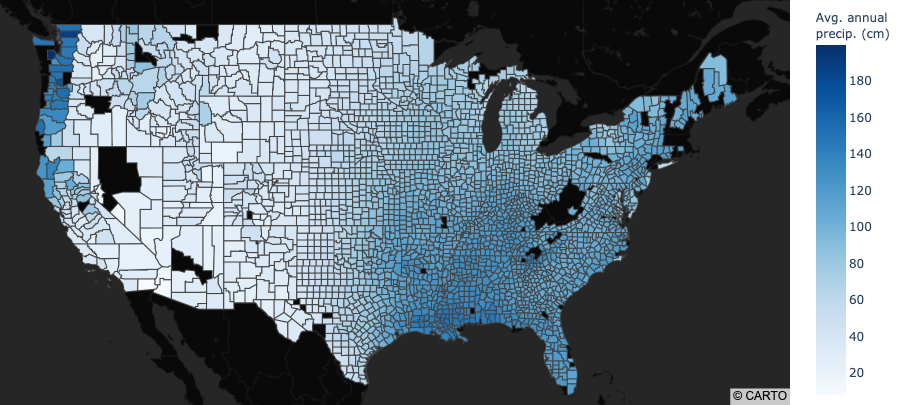

In [22]:
mapping(county_df[county_df.variety == 'base'],
        'annual_precip_cm', 'Blues', 'Avg. annual<br>precip. (cm)')

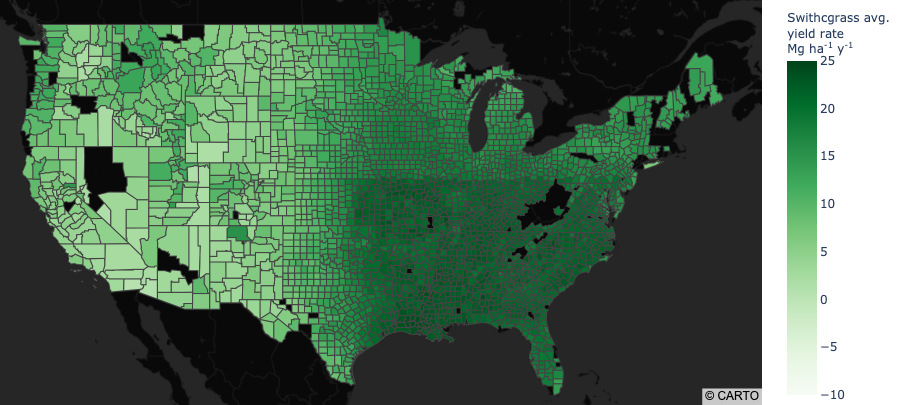

In [23]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha', 'Greens', 'Swithcgrass avg.<br>yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-10, 25]})

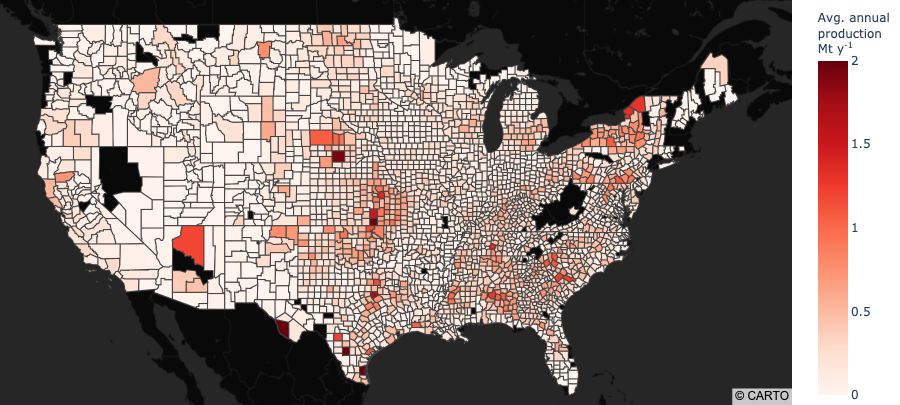

In [24]:
mapping(county_df[county_df.variety == 'base'],
        'prod_Mt', 'Reds', 'Avg. annual<br>production<br>Mt y<sup>-1</sup>',
        kwargs={"range_color": [0.0, 2.0]})

# Inter-annual yield variability

## Map yield STD & COV

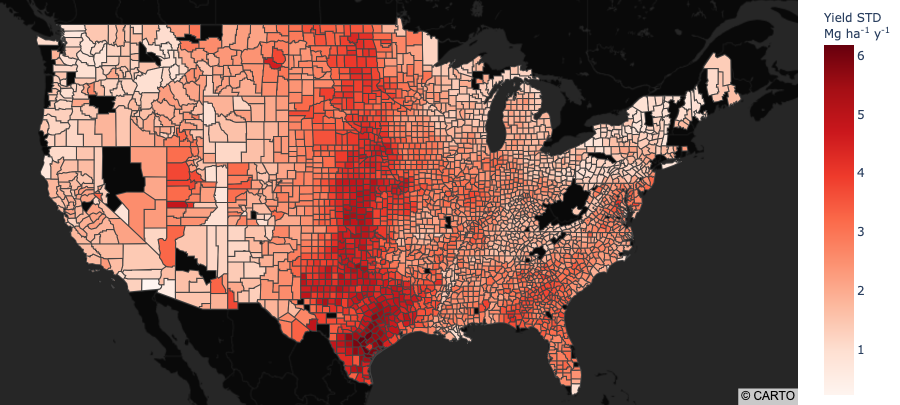

In [25]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_std', 'Reds', 'Yield STD<br>Mg ha<sup>-1</sup> y<sup>-1</sup>')

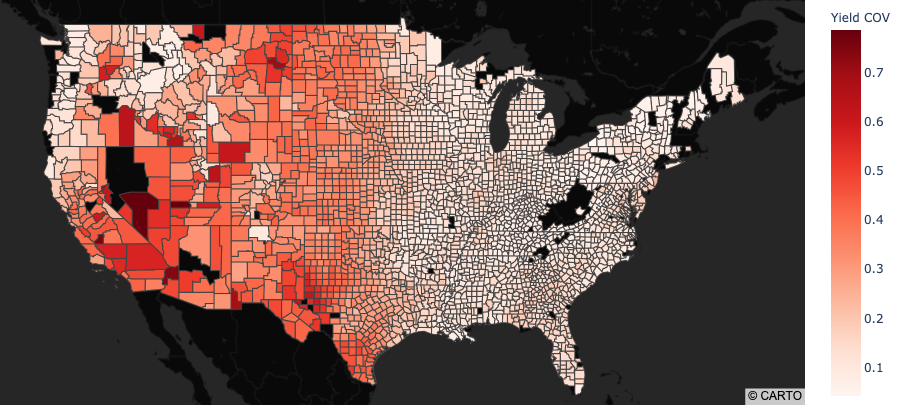

In [26]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_per_ha_cov', 'Reds', 'Yield COV')

## Map yield-precip correlation

In [27]:
%%time

# create list to store regression results
reg_results = []

# create dataframe to store full annual_df plus a normalized column
norm_cols = [x for x in annual_df.columns]
norm_df = pd.DataFrame(columns=norm_cols)

# subset the annual data from each county, one at a time
counties = annual_df['fips'].unique()
for county in counties:
    my_county = annual_df[annual_df['fips'] == county]
    
    # regress annual yield vs. annual precipitation w/in the county
    X = my_county.annual_precip_cm
    Y = my_county.yield_Mg_per_ha
    X2 = sm.add_constant(X)
    est = sm.OLS(Y, X2)
    est2 = est.fit()
    r2 = est2.rsquared_adj
    
    reg_results.append([county, r2])
    
    # normalize annual results against best-yielding year
    best_yield = my_county.yield_Mg_per_ha.max()
    my_county['norm_yield'] = my_county.yield_Mg_per_ha / best_yield
    
    norm_df = pd.concat([norm_df, my_county], axis=0)

norm_df.to_csv(base_sims+'-annual_norm.csv', index=False)
    
# convert regression results array to DataFrame
reg_df = pd.DataFrame(reg_results, columns =['fips', 'r2'])
reg_df

<timed exec>:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



CPU times: user 43.8 s, sys: 6.61 s, total: 50.4 s
Wall time: 51.6 s


fips        r2
0     01001  0.478936
1     01003  0.181223
2     01005  0.502560
3     01007  0.251234
4     01009  0.128837
...     ...       ...
2882  56037  0.543413
2883  56039  0.107651
2884  56041  0.414676
2885  56043  0.612237
2886  56045  0.533676

[2887 rows x 2 columns]

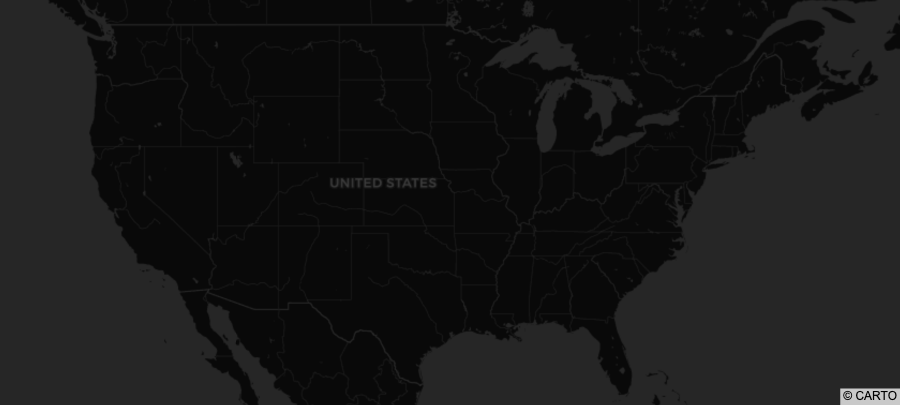

In [28]:
mapping(reg_df,
        'r2', 'Purples', 'Yield-precip<br>correlation strength<br>r<sup>2</sup>')

## Farm Resource Regions

We can discretize our yield-vs-precipitation analysis by Farm Resource Region, using the FIPS lookup table archived at https://wayback.archive-it.org/5923/20110913212900/http:/www.ers.usda.gov/Briefing/ARMS/resourceregions/resourceregions.htm

In [29]:
frr_df = pd.read_excel("FRR_data.xls", sheet_name='data')
lookup_df = pd.read_excel("FRR_data.xls", sheet_name='lookup')
frr_df = pd.merge(lookup_df, frr_df, on='FRR', validate="1:m")
frr_df['fips'] = frr_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
frr_df

FRR         Region_name   fips
0       1           Heartland  17011
1       1           Heartland  17015
2       1           Heartland  17073
3       1           Heartland  17085
4       1           Heartland  17103
...   ...                 ...    ...
3107    9  Mississippi Portal  47125
3108    9  Mississippi Portal  47135
3109    9  Mississippi Portal  47147
3110    9  Mississippi Portal  47161
3111    9  Mississippi Portal  47181

[3112 rows x 3 columns]

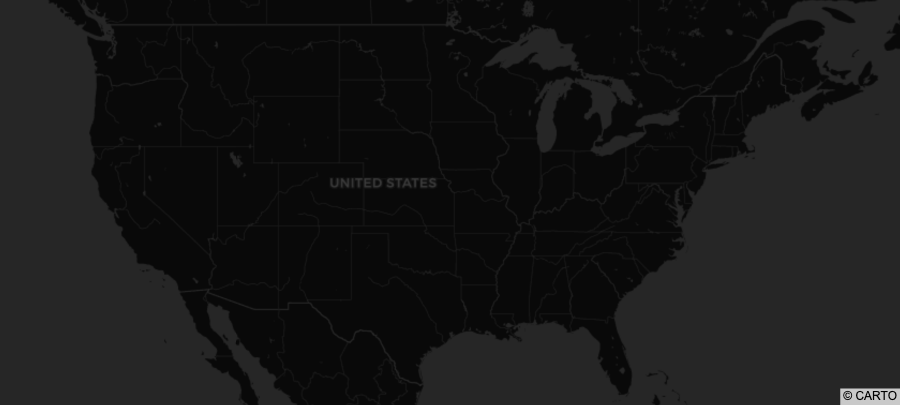

In [30]:
my_map = px.choropleth_mapbox(frr_df, geojson=counties, locations='fips',
                              color='Region_name',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Region_name': 'Farm Resource Region'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("FRR.png")
    display(Image(filename="FRR.png"))
my_map.write_image("FRR.pdf")

In [31]:
# merge FRR data into normalized annual dataframe

norm_df = pd.merge(norm_df, frr_df, on='fips')
norm_df

fips variety  time        tot_ha   prod_Mt  yield_Mg_per_ha  \
0       01001    base  2022  31214.547584  0.510333        16.349190   
1       01001    base  2023  31214.547584  0.586823        18.799675   
2       01001    base  2024  31214.547584  0.739997        23.706802   
3       01001    base  2025  31214.547584  0.724218        23.201291   
4       01001    base  2026  31214.547584  0.728972        23.353610   
...       ...     ...   ...           ...       ...              ...   
101005  56045    base  2052  49942.057254  0.404776         8.104920   
101006  56045    base  2053  49942.057254  0.301059         6.028175   
101007  56045    base  2054  49942.057254  0.170945         3.422875   
101008  56045    base  2055  49942.057254  0.276574         5.537889   
101009  56045    base  2056  49942.057254  0.351972         7.047606   

        dSOC_MgC_per_ha  dN2ON_kgN_per_ha  iN2ON_kgN_per_ha  kgCH4_ox_per_ha  \
0             -0.466800          0.938132          0.387267         1.749208   
1             -0.135422          1.074047          0.392042         1.948676   
2             -0.304721          1.348264          0.548503         1.659025   
3             -0.303140          1.413249          0.551111         1.570409   
4             -0.242581          1.469613          0.380166         1.674398   
...                 ...               ...               ...              ...   
101005         0.166503          0.807732          0.062300         2.664367   
101006         0.204331          0.824704          0.266043         2.685649   
101007         0.121344          0.680734          0.038478         2.872895   
101008         0.091714          1.468600          0.732901         2.402034   
101009         0.024185          1.800729          0.126804         2.420447   

        ghg_MgCO2e_per_ha  volit_kgN_per_ha  leached_kgN_per_ha  \
0                2.213224          7.135401           40.196248   
1                1.052026         10.317146           36.697783   
2                1.859768         12.711367           54.108848   
3                1.884601         12.486592           54.626172   
4                1.612090         12.599415           31.883211   
...                   ...               ...                 ...   
101005          -0.322445          4.805261            0.466223   
101006          -0.369755          3.790933           28.716341   
101007          -0.225613          2.426031            0.000371   
101008           0.513279          3.445930           90.820559   
101009           0.646127          4.249247            8.897039   

        annual_precip_cm  leach_volit_frac  norm_yield  FRR  \
0             127.492916          0.631089    0.655279    6   
1             118.404408          0.626866    0.753495    6   
2             142.141696          0.890936    0.950174    6   
3             173.520361          0.894837    0.929913    6   
4             121.974052          0.593102    0.936018    6   
...                  ...               ...         ...  ...   
101005         36.799547          0.070286    0.809152    3   
101006         33.363050          0.433430    0.601821    3   
101007         20.742364          0.032352    0.341722    3   
101008         51.009101          1.256887    0.552874    3   
101009         32.953848          0.175284    0.703596    3   

                  Region_name  
0           Southern Seaboard  
1           Southern Seaboard  
2           Southern Seaboard  
3           Southern Seaboard  
4           Southern Seaboard  
...                       ...  
101005  Northern Great Plains  
101006  Northern Great Plains  
101007  Northern Great Plains  
101008  Northern Great Plains  
101009  Northern Great Plains  

[101010 rows x 18 columns]

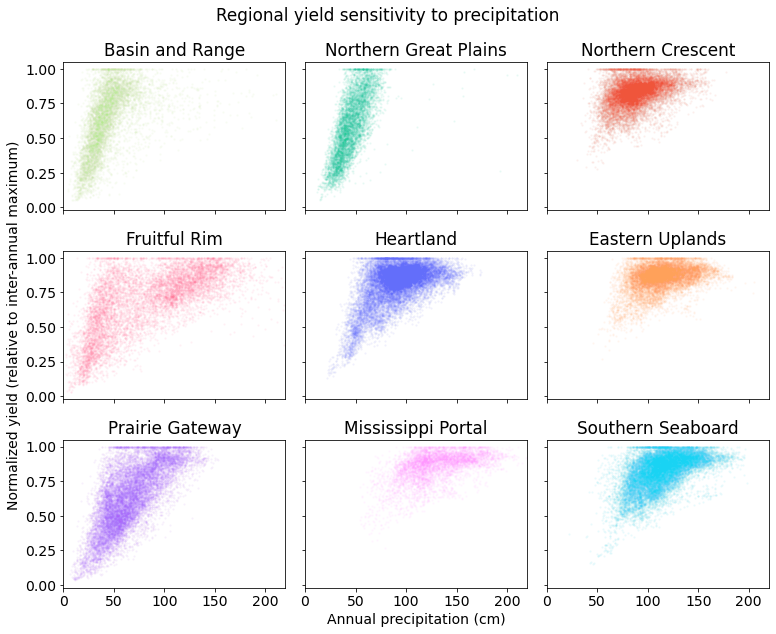

In [32]:
frr_panels = [
[['Basin and Range', '#B6E880'], ['Northern Great Plains', '#00CC96'], ['Northern Crescent', '#EF553B']],
[['Fruitful Rim', '#FF6692'], ['Heartland', '#636EFA'], ['Eastern Uplands', '#FFA15A']],
[['Prairie Gateway', '#AB63FA'], ['Mississippi Portal', '#FF97FF'], ['Southern Seaboard', '#19D3F3']]
]

matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(11, 9), nrows=len(frr_panels), ncols=len(frr_panels[1]), sharex=True, sharey=True)
fig.suptitle('Regional yield sensitivity to precipitation')
ax[2, 1].set_xlabel("Annual precipitation (cm)")
ax[1, 0].set_ylabel("Normalized yield (relative to inter-annual maximum)")
ax[0, 0].set_xlim([0, 220])

# iterate through panel structure
for i in range(len(frr_panels)):
    for j in range(len(frr_panels[i])):
        region, color = frr_panels[i][j]
        ax[i, j].set_title(region)
        data = norm_df[norm_df.Region_name == region]
        
        # plot normalized yield response to precipitation
        ax[i, j].scatter(data.annual_precip_cm, data.norm_yield, color=color, alpha=0.05, s=2)

plt.tight_layout()
plt.savefig('Norm_yield-vs-precip-by-FRR.pdf')
plt.savefig('Norm_yield-vs-precip-by-FRR.png')

# Yield comparisons

In [33]:
cabbi_file = "miscanthus_county_averages_20211223.csv"
cabbi_df = pd.read_csv(cabbi_file)
cabbi_df['fips'] = cabbi_df['nearestfips'].apply(lambda x: '{0:0>5}'.format(x))
cabbi_df['CABBI_yield_Mg_per_ha'] = cabbi_df['crmvst'] * 0.01 * (1.0/0.45)
cabbi_df

nearestfips      crmvst        lat        long   fips  \
0            1001  632.324454  32.473627  -86.643715  01001   
1            1003  507.082259  30.526641  -87.669597  01003   
2            1005  619.502199  31.832132  -85.495884  01005   
3            1007  692.846465  33.002928  -87.135046  01007   
4            1009  739.274274  34.050116  -86.545193  01009   
...           ...         ...        ...         ...    ...   
2619        56033  397.252944  44.966671 -107.068836  56033   
2620        56035  278.677739  42.714495 -110.078551  56035   
2621        56037  126.148407  42.105203 -109.493924  56037   
2622        56043  283.786050  44.065463 -107.906396  56043   
2623        56045  464.511005  44.198669 -104.398670  56045   

      CABBI_yield_Mg_per_ha  
0                 14.051655  
1                 11.268495  
2                 13.766716  
3                 15.396588  
4                 16.428317  
...                     ...  
2619               8.827843  
2620               6.192839  
2621               2.803298  
2622               6.306357  
2623              10.322467  

[2624 rows x 6 columns]

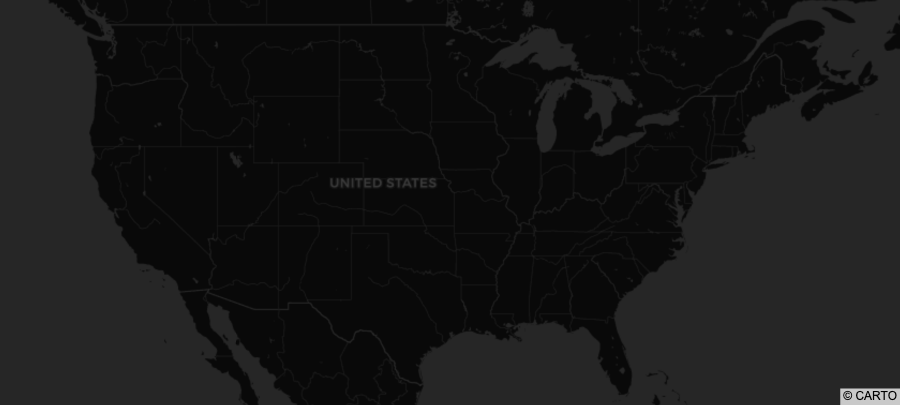

In [34]:
mapping(cabbi_df,
        'CABBI_yield_Mg_per_ha', 'Greens', 'Avg. yield rate<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [0, 25]})

In [35]:
fips_df = pd.read_csv('All_FIPS.csv')
fips_df['fips'] = fips_df['FIPS'].apply(lambda x: '{0:0>5}'.format(x))

In [36]:
comp_df = pd.merge(county_df, cabbi_df, on='fips', how='outer')
comp_df = pd.merge(fips_df, comp_df, on='fips', how='outer')
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  dSOC_MgC_per_ha  ...  leached_kgN_per_ha  \
0           21.453964        -0.145183  ...           41.222530   
1           21.638478        -0.159278  ...           47.680970   
2           22.020761        -0.161873  ...           38.122601   
3           22.452943        -0.111036  ...           36.318255   
4           21.753865        -0.046419  ...           33.420151   
...               ...              ...  ...                 ...   
3129         9.964753         0.119342  ...           30.767979   
3130         4.788846         0.076301  ...           30.245258   
3131         6.525234         0.077791  ...           17.093701   
3132         6.120595         0.116365  ...           10.542336   
3133              NaN              NaN  ...                 NaN   

      annual_precip_cm  leach_volit_frac  yield_Mg_per_ha_std  \
0           126.384666          0.704703             2.967179   
1           142.606667          0.791687             2.146405   
2           118.420994          0.667964             3.278115   
3           131.636427          0.645685             2.474065   
4           126.233706          0.601991             2.616056   
...                ...               ...                  ...   
3129         71.297985          0.485087             0.924592   
3130         34.756267          0.444187             2.058416   
3131         38.533469          0.280592             2.237540   
3132         37.755811          0.190909             2.092920   
3133               NaN               NaN                  NaN   

      yield_Mg_per_ha_cov  nearestfips      crmvst        lat        long  \
0                0.138304       1001.0  632.324454  32.473627  -86.643715   
1                0.099194       1003.0  507.082259  30.526641  -87.669597   
2                0.148865       1005.0  619.502199  31.832132  -85.495884   
3                0.110189       1007.0  692.846465  33.002928  -87.135046   
4                0.120257       1009.0  739.274274  34.050116  -86.545193   
...                   ...          ...         ...        ...         ...   
3129             0.092786          NaN         NaN        NaN         NaN   
3130             0.429835          NaN         NaN        NaN         NaN   
3131             0.342906      56043.0  283.786050  44.065463 -107.906396   
3132             0.341947      56045.0  464.511005  44.198669 -104.398670   
3133                  NaN      51595.0  928.972380  36.717375  -77.437083   

      CABBI_yield_Mg_per_ha  
0                 14.051655  
1                 11.268495  
2                 13.766716  
3                 15.396588  
4                 16.428317  
...                     ...  
3129                    NaN  
3130                    NaN  
3131               6.306357  
3132              10.322467  
3133              20.643831  

[3134 rows x 25 columns]

In [37]:
# model yields in PRISM-ELM paper colors

# map continuous yields to discreet bins
def yield_rules(col):

    rules = {
        '0-1': (comp_df[col] < 1.0),
        '1-3': (comp_df[col] >= 1.0) & (comp_df[col] < 3.0),
        '3-6': (comp_df[col] >= 3.0) & (comp_df[col] < 6.0),
        '6-10': (comp_df[col] >= 6.0) & (comp_df[col] < 10.0),
        '10-14': (comp_df[col] >= 10.0) & (comp_df[col] < 14.0),
        '14-18': (comp_df[col] >= 14.0) & (comp_df[col] < 18.0),
        '18-22': (comp_df[col] >= 18.0) & (comp_df[col] < 22.0),
        '>22': (comp_df[col] >= 22.0)
    }
    return rules

comp_df['SWG_yield_bins'] = np.select(yield_rules('yield_Mg_per_ha').values(), yield_rules('yield_Mg_per_ha').keys(), default="")
comp_df['Misc_yield_bins'] = np.select(yield_rules('CABBI_yield_Mg_per_ha').values(), yield_rules('CABBI_yield_Mg_per_ha').keys(), default="")
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  dSOC_MgC_per_ha  ...  leach_volit_frac  \
0           21.453964        -0.145183  ...          0.704703   
1           21.638478        -0.159278  ...          0.791687   
2           22.020761        -0.161873  ...          0.667964   
3           22.452943        -0.111036  ...          0.645685   
4           21.753865        -0.046419  ...          0.601991   
...               ...              ...  ...               ...   
3129         9.964753         0.119342  ...          0.485087   
3130         4.788846         0.076301  ...          0.444187   
3131         6.525234         0.077791  ...          0.280592   
3132         6.120595         0.116365  ...          0.190909   
3133              NaN              NaN  ...               NaN   

      yield_Mg_per_ha_std  yield_Mg_per_ha_cov  nearestfips      crmvst  \
0                2.967179             0.138304       1001.0  632.324454   
1                2.146405             0.099194       1003.0  507.082259   
2                3.278115             0.148865       1005.0  619.502199   
3                2.474065             0.110189       1007.0  692.846465   
4                2.616056             0.120257       1009.0  739.274274   
...                   ...                  ...          ...         ...   
3129             0.924592             0.092786          NaN         NaN   
3130             2.058416             0.429835          NaN         NaN   
3131             2.237540             0.342906      56043.0  283.786050   
3132             2.092920             0.341947      56045.0  464.511005   
3133                  NaN                  NaN      51595.0  928.972380   

            lat        long  CABBI_yield_Mg_per_ha  SWG_yield_bins  \
0     32.473627  -86.643715              14.051655           18-22   
1     30.526641  -87.669597              11.268495           18-22   
2     31.832132  -85.495884              13.766716             >22   
3     33.002928  -87.135046              15.396588             >22   
4     34.050116  -86.545193              16.428317           18-22   
...         ...         ...                    ...             ...   
3129        NaN         NaN                    NaN            6-10   
3130        NaN         NaN                    NaN             3-6   
3131  44.065463 -107.906396               6.306357            6-10   
3132  44.198669 -104.398670              10.322467            6-10   
3133  36.717375  -77.437083              20.643831                   

      Misc_yield_bins  
0               14-18  
1               10-14  
2               10-14  
3               14-18  
4               14-18  
...               ...  
3129                   
3130                   
3131             6-10  
3132            10-14  
3133            18-22  

[3134 rows x 27 columns]

In [38]:
prism_colors = {
    '0-1': 'rgb(135,110,64)',
    '1-3': 'rgb(204,168,100)',
    '3-6': 'rgb(243,217,164)',
    '6-10': 'rgb(254,255,214)',
    '10-14': 'rgb(169,232,145)',
    '14-18': 'rgb(108,194,111)',
    '18-22': 'rgb(70,153,71)',
    '>22': 'rgb(38,114,0)'
    }


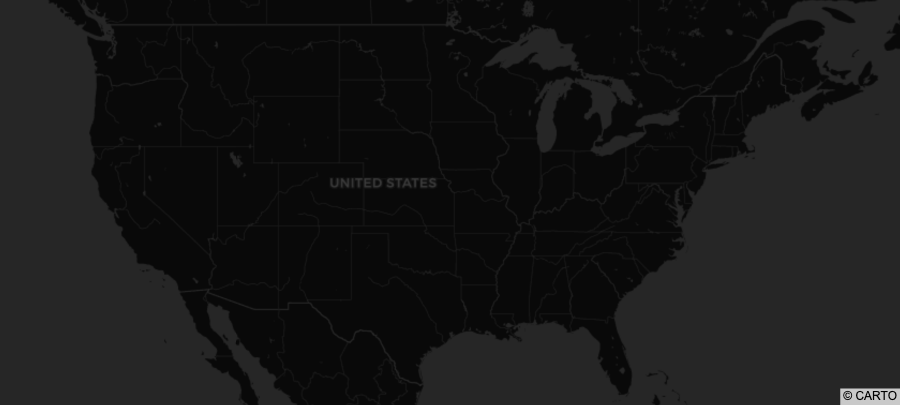

In [39]:
my_map = px.choropleth_mapbox(comp_df[comp_df.SWG_yield_bins != ''], geojson=counties, locations='fips',
                              color='SWG_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'SWG_yield_bins': 'Switchgrass yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"SWG_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'SWG_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image(name+".png")
    display(Image(filename=(name+".png")))
my_map.write_image(name+".pdf")

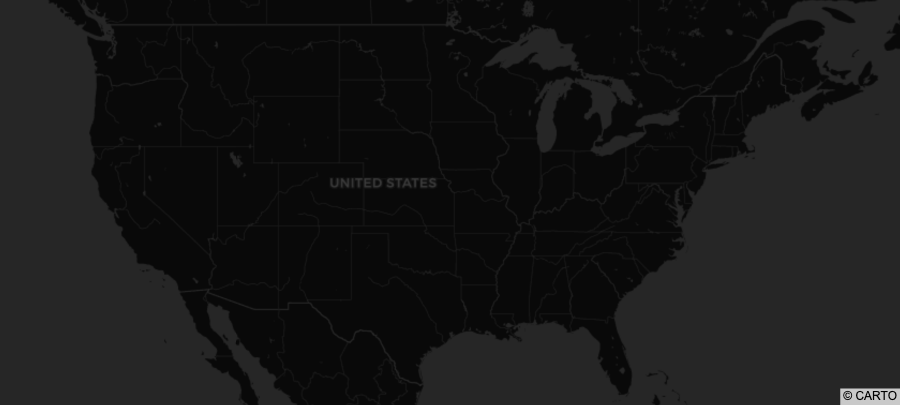

In [40]:
my_map = px.choropleth_mapbox(comp_df[comp_df.Misc_yield_bins != ''], geojson=counties, locations='fips',
                              color='Misc_yield_bins',
                              color_discrete_map=prism_colors,
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'Misc_yield_bins': 'Miscanthus yield<br>Mg ha<sup>-1</sup> y<sup>-1</sup>'},
                              category_orders={"Misc_yield_bins": ['0-1', '1-3', '3-6', '6-10', '10-14', '14-18', '18-22', '>22']})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
my_map.update_traces(marker_line_width=0.2)

name = 'Misc_prism_yield'
if interactive_map:
    my_map.show()
else:
    my_map.write_image(name+".png")
    display(Image(filename=(name+".png")))
my_map.write_image(name+".pdf")

In [41]:
rules = {
    'Both': (~comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No switchgrass': (comp_df.yield_Mg_per_ha.isna()) & (~comp_df.CABBI_yield_Mg_per_ha.isna()),
    'No miscanthus': (~comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna()),
    'Neither': (comp_df.yield_Mg_per_ha.isna()) & (comp_df.CABBI_yield_Mg_per_ha.isna())
}

comp_df['missing'] = np.select(rules.values(), rules.keys(), default="")
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  dSOC_MgC_per_ha  ...  yield_Mg_per_ha_std  \
0           21.453964        -0.145183  ...             2.967179   
1           21.638478        -0.159278  ...             2.146405   
2           22.020761        -0.161873  ...             3.278115   
3           22.452943        -0.111036  ...             2.474065   
4           21.753865        -0.046419  ...             2.616056   
...               ...              ...  ...                  ...   
3129         9.964753         0.119342  ...             0.924592   
3130         4.788846         0.076301  ...             2.058416   
3131         6.525234         0.077791  ...             2.237540   
3132         6.120595         0.116365  ...             2.092920   
3133              NaN              NaN  ...                  NaN   

      yield_Mg_per_ha_cov  nearestfips      crmvst        lat        long  \
0                0.138304       1001.0  632.324454  32.473627  -86.643715   
1                0.099194       1003.0  507.082259  30.526641  -87.669597   
2                0.148865       1005.0  619.502199  31.832132  -85.495884   
3                0.110189       1007.0  692.846465  33.002928  -87.135046   
4                0.120257       1009.0  739.274274  34.050116  -86.545193   
...                   ...          ...         ...        ...         ...   
3129             0.092786          NaN         NaN        NaN         NaN   
3130             0.429835          NaN         NaN        NaN         NaN   
3131             0.342906      56043.0  283.786050  44.065463 -107.906396   
3132             0.341947      56045.0  464.511005  44.198669 -104.398670   
3133                  NaN      51595.0  928.972380  36.717375  -77.437083   

      CABBI_yield_Mg_per_ha  SWG_yield_bins  Misc_yield_bins         missing  
0                 14.051655           18-22            14-18            Both  
1                 11.268495           18-22            10-14            Both  
2                 13.766716             >22            10-14            Both  
3                 15.396588             >22            14-18            Both  
4                 16.428317           18-22            14-18            Both  
...                     ...             ...              ...             ...  
3129                    NaN            6-10                    No miscanthus  
3130                    NaN             3-6                    No miscanthus  
3131               6.306357            6-10             6-10            Both  
3132              10.322467            6-10            10-14            Both  
3133              20.643831                            18-22  No switchgrass  

[3134 rows x 28 columns]

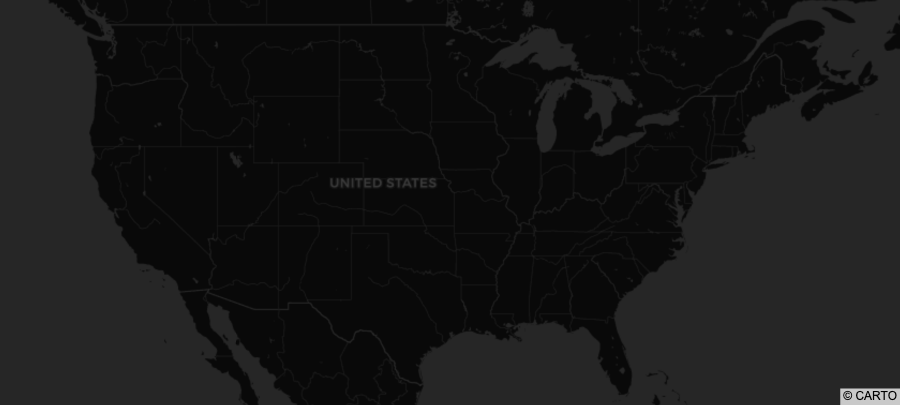

In [42]:
# comp_df = comp_df[comp_df.missing == "Both"]
comp_df['Misc-SWG_yield_per_ha'] = comp_df.CABBI_yield_Mg_per_ha - comp_df.yield_Mg_per_ha

mapping(comp_df,
        'Misc-SWG_yield_per_ha', 'BrBG', 'Miscanthus<br>yield advantage<br>Mg ha<sup>-1</sup> y<sup>-1</sup>',
        kwargs={"range_color": [-12, 12]})

# Land use and modeling extent

## Cropland & abandoned land

In [43]:
coa_df = pd.read_csv('/Users/53f/ORNL_OneDrive/Notebooks/SPARC/NARR-CoA_comparison/coa_ha.csv')
coa_df['fips'] = coa_df['fips'].apply(lambda x: '{0:0>5}'.format(x))
coa_df

fips    county_ha   CoA_harv_ha  CoA_fail_ha  CoA_fallow_ha  \
0     01001   153958.924  11151.932102   400.639140     270.330248   
1     01003   411754.056  38162.294486  1587.987864     225.814788   
2     01005   229182.884  10210.632466   211.246092     578.700980   
3     01007   161248.738   4375.465032          NaN            NaN   
4     01009   166996.984  12582.092426   134.760438     669.350644   
...     ...          ...           ...          ...            ...   
3096  56037  2700502.091  11476.085588   177.252468     790.351758   
3097  56039  1034803.161   5177.957370          NaN            NaN   
3098  56041   539047.376  19408.740560          NaN            NaN   
3099  56043   579784.191  13484.137520   503.024698    1017.785290   
3100  56045   621105.051   8733.528566  2435.400348    1998.339468   

      CoA_harv_0_ha  CoA_fail_0_ha  CoA_fallow_0_ha  CoA_tot_0_ha  \
0      11151.932102     400.639140       270.330248  11822.901490   
1      38162.294486    1587.987864       225.814788  39976.097138   
2      10210.632466     211.246092       578.700980  11000.579538   
3       4375.465032       0.000000         0.000000   4375.465032   
4      12582.092426     134.760438       669.350644  13386.203508   
...             ...            ...              ...           ...   
3096   11476.085588     177.252468       790.351758  12443.689814   
3097    5177.957370       0.000000         0.000000   5177.957370   
3098   19408.740560       0.000000         0.000000  19408.740560   
3099   13484.137520     503.024698      1017.785290  15004.947508   
3100    8733.528566    2435.400348      1998.339468  13167.268382   

      CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  CoA_fallow_pct  
0        7.679257      7.243446      0.260225        0.175586  
1        9.708732      9.268226      0.385664        0.054842  
2        4.799913      4.455233      0.092174        0.252506  
3        2.713488      2.713488      0.000000        0.000000  
4        8.015835      7.534323      0.080696        0.400816  
...           ...           ...           ...             ...  
3096     0.460792      0.424961      0.006564        0.029267  
3097     0.500381      0.500381      0.000000        0.000000  
3098     3.600563      3.600563      0.000000        0.000000  
3099     2.588023      2.325717      0.086761        0.175546  
3100     2.119974      1.406127      0.392108        0.321739  

[3101 rows x 13 columns]

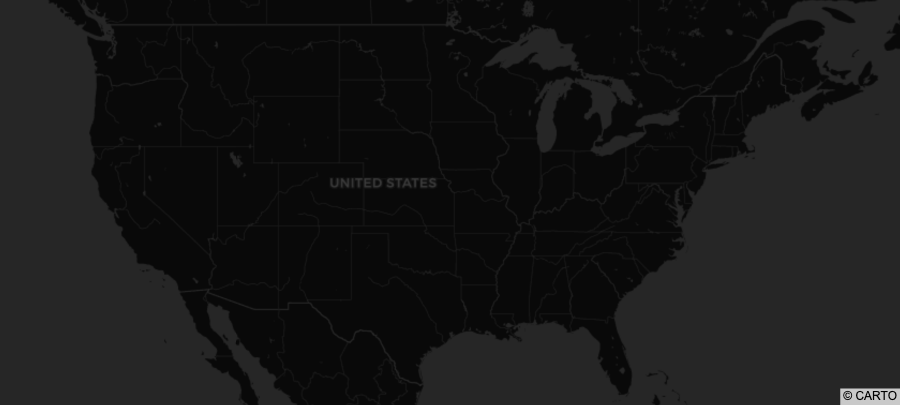

In [44]:
mapping(coa_df,
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 100]})

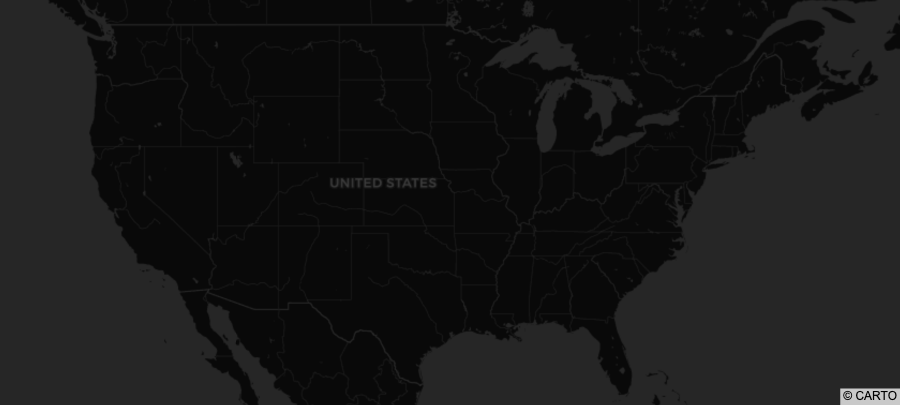

In [45]:
mapping(county_df[county_df.variety == 'base'],
        'tot_ha', 'Oranges', 'Abandoned land<br>area (ha)',
       kwargs={"range_color": [0, 120e3]})

In [46]:
comp_df = pd.merge(comp_df, coa_df, on='fips', how='outer')
comp_df['abandoned_pct'] = (comp_df.tot_ha / comp_df.county_ha) * 100.0
comp_df['abandoned_to_active_cropland'] = comp_df.tot_ha / comp_df.CoA_tot_0_ha
comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  dSOC_MgC_per_ha  ...  CoA_harv_0_ha  CoA_fail_0_ha  \
0           21.453964        -0.145183  ...   11151.932102     400.639140   
1           21.638478        -0.159278  ...   38162.294486    1587.987864   
2           22.020761        -0.161873  ...   10210.632466     211.246092   
3           22.452943        -0.111036  ...    4375.465032       0.000000   
4           21.753865        -0.046419  ...   12582.092426     134.760438   
...               ...              ...  ...            ...            ...   
3129         9.964753         0.119342  ...    5177.957370       0.000000   
3130         4.788846         0.076301  ...   19408.740560       0.000000   
3131         6.525234         0.077791  ...   13484.137520     503.024698   
3132         6.120595         0.116365  ...    8733.528566    2435.400348   
3133              NaN              NaN  ...            NaN            NaN   

      CoA_fallow_0_ha  CoA_tot_0_ha  CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  \
0          270.330248  11822.901490     7.679257      7.243446      0.260225   
1          225.814788  39976.097138     9.708732      9.268226      0.385664   
2          578.700980  11000.579538     4.799913      4.455233      0.092174   
3            0.000000   4375.465032     2.713488      2.713488      0.000000   
4          669.350644  13386.203508     8.015835      7.534323      0.080696   
...               ...           ...          ...           ...           ...   
3129         0.000000   5177.957370     0.500381      0.500381      0.000000   
3130         0.000000  19408.740560     3.600563      3.600563      0.000000   
3131      1017.785290  15004.947508     2.588023      2.325717      0.086761   
3132      1998.339468  13167.268382     2.119974      1.406127      0.392108   
3133              NaN           NaN          NaN           NaN           NaN   

      CoA_fallow_pct  abandoned_pct  abandoned_to_active_cropland  
0           0.175586      20.274595                      2.640177  
1           0.054842       4.807263                      0.495148  
2           0.252506      14.987481                      3.122448  
3           0.000000       3.764664                      1.387389  
4           0.400816      16.747597                      2.089314  
...              ...            ...                           ...  
3129        0.000000       0.744853                      1.488572  
3130        0.000000       0.415802                      0.115482  
3131        0.175546       0.537383                      0.207642  
3132        0.321739       8.040839                      3.792894  
3133             NaN            NaN                           NaN  

[3134 rows x 43 columns]

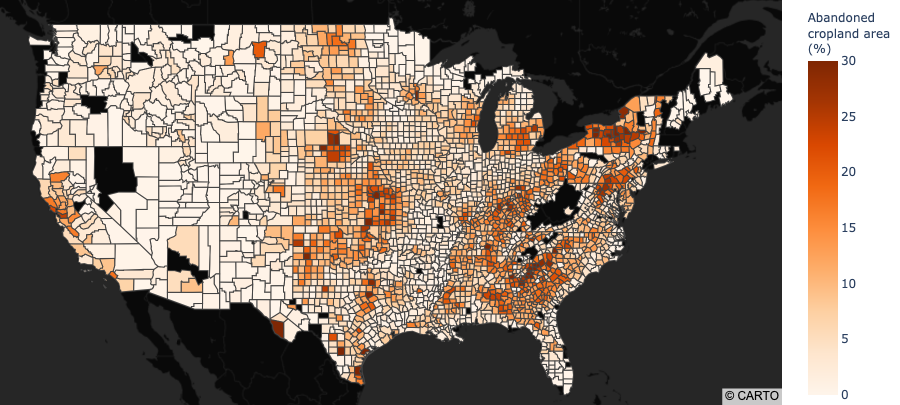

In [71]:
mapping(comp_df,
        'abandoned_pct', 'Oranges', 'Abandoned<br>cropland area<br>(%)',
       kwargs={"range_color": [0, 30]})

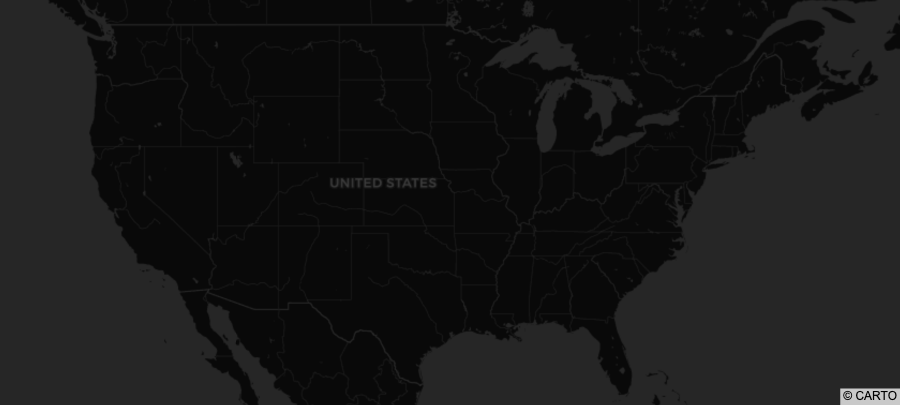

In [48]:
mapping(comp_df,
        'abandoned_to_active_cropland', 'RdBu_r', 'Abandoned:active<br>cropland',
       kwargs={"range_color": [0, 2]})

## Missing counties

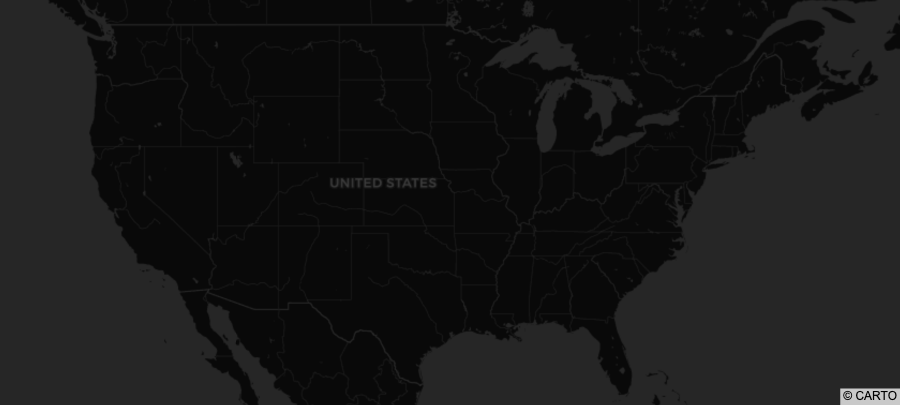

In [49]:
missing_df = fips_df.merge(county_df.drop_duplicates(), on='fips', how='left', indicator=True)

mapping(missing_df[missing_df._merge == 'left_only'],
        'FIPS', 'Viridis', '', kwargs={"range_color": [0, 1000]})

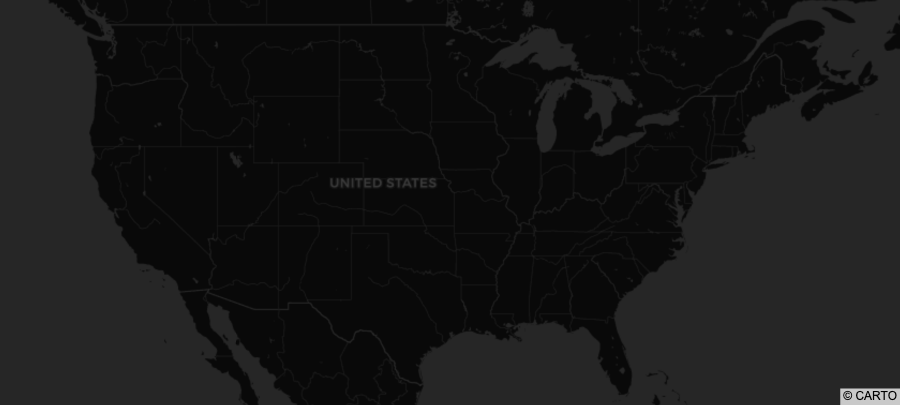

In [50]:
missing_df = comp_df[comp_df.missing != "Both"].copy()

my_map = px.choropleth_mapbox(missing_df, geojson=counties, locations='fips',
                              color='missing',
                              mapbox_style='carto-darkmatter',
                              zoom=map_zoom,
                              center={"lat": cen_lat, "lon": cen_lon},
                              labels={'missing': 'Missing data'})
my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                     margin={"r":0,"t":0,"l":0,"b":0})
if interactive_map:
    my_map.show()
else:
    my_map.write_image("Missing.png")
    display(Image(filename="Missing.png"))
my_map.write_image("Missing.pdf")

In [51]:
# convert 'missing' column to binary indicators for miscanthus and switchgrass data separately
rules = {
    'Data': comp_df.missing.isin(['Both', 'No switchgrass']),
    'No data': comp_df.missing.isin(['No miscanthus', "Neither"])
}
comp_df['Misc_data'] = np.select(rules.values(), rules.keys())

rules = {
    'Data': comp_df.missing.isin(['Both', 'No miscanthus']),
    'No data': comp_df.missing.isin(['No switchgrass', "Neither"])
}
comp_df['SWG_data'] = np.select(rules.values(), rules.keys())

comp_df

FIPS    County    State   ST   fips variety        tot_ha   prod_Mt  \
0      1001.0   Autauga  Alabama   AL  01001    base  31214.547584  0.669676   
1      1003.0   Baldwin  Alabama   AL  01003    base  19794.098716  0.428314   
2      1005.0   Barbour  Alabama   AL  01005    base  34348.741190  0.756385   
3      1007.0      Bibb  Alabama   AL  01007    base   6070.472827  0.136300   
4      1009.0    Blount  Alabama   AL  01009    base  27967.981922  0.608412   
...       ...       ...      ...  ...    ...     ...           ...       ...   
3129  56039.0     Teton  Wyoming   WY  56039    base   7707.760967  0.076806   
3130  56041.0     Uinta  Wyoming   WY  56041    base   2241.368860  0.010734   
3131  56043.0  Washakie  Wyoming   WY  56043    base   3115.660099  0.020330   
3132  56045.0    Weston  Wyoming   WY  56045    base  49942.057254  0.305675   
3133      NaN       NaN      NaN  NaN  51595     NaN           NaN       NaN   

      yield_Mg_per_ha  dSOC_MgC_per_ha  ...  CoA_fallow_0_ha  CoA_tot_0_ha  \
0           21.453964        -0.145183  ...       270.330248  11822.901490   
1           21.638478        -0.159278  ...       225.814788  39976.097138   
2           22.020761        -0.161873  ...       578.700980  11000.579538   
3           22.452943        -0.111036  ...         0.000000   4375.465032   
4           21.753865        -0.046419  ...       669.350644  13386.203508   
...               ...              ...  ...              ...           ...   
3129         9.964753         0.119342  ...         0.000000   5177.957370   
3130         4.788846         0.076301  ...         0.000000  19408.740560   
3131         6.525234         0.077791  ...      1017.785290  15004.947508   
3132         6.120595         0.116365  ...      1998.339468  13167.268382   
3133              NaN              NaN  ...              NaN           NaN   

      CoA_tot_pct  CoA_harv_pct  CoA_fail_pct  CoA_fallow_pct  abandoned_pct  \
0        7.679257      7.243446      0.260225        0.175586      20.274595   
1        9.708732      9.268226      0.385664        0.054842       4.807263   
2        4.799913      4.455233      0.092174        0.252506      14.987481   
3        2.713488      2.713488      0.000000        0.000000       3.764664   
4        8.015835      7.534323      0.080696        0.400816      16.747597   
...           ...           ...           ...             ...            ...   
3129     0.500381      0.500381      0.000000        0.000000       0.744853   
3130     3.600563      3.600563      0.000000        0.000000       0.415802   
3131     2.588023      2.325717      0.086761        0.175546       0.537383   
3132     2.119974      1.406127      0.392108        0.321739       8.040839   
3133          NaN           NaN           NaN             NaN            NaN   

      abandoned_to_active_cropland  Misc_data  SWG_data  
0                         2.640177       Data      Data  
1                         0.495148       Data      Data  
2                         3.122448       Data      Data  
3                         1.387389       Data      Data  
4                         2.089314       Data      Data  
...                            ...        ...       ...  
3129                      1.488572    No data      Data  
3130                      0.115482    No data      Data  
3131                      0.207642       Data      Data  
3132                      3.792894       Data      Data  
3133                           NaN       Data   No data  

[3134 rows x 45 columns]

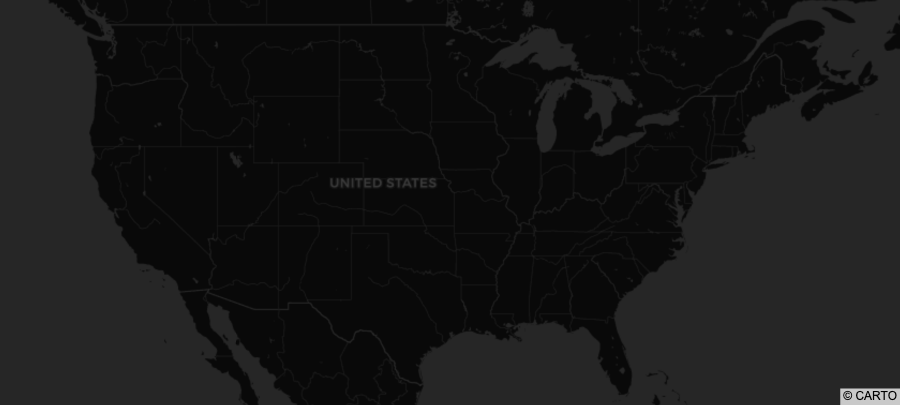

In [52]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 100]})

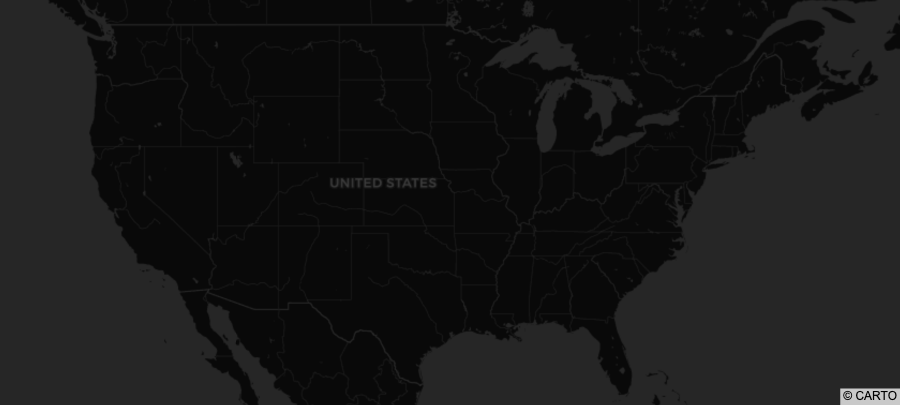

In [53]:
mapping(comp_df[comp_df.missing.isin(['No miscanthus', 'Neither'])],
        'tot_ha', 'Oranges', 'Abandoned land<br>area (ha)', descrip='_Misc_missing',
       kwargs={"range_color": [0, 120e3]})

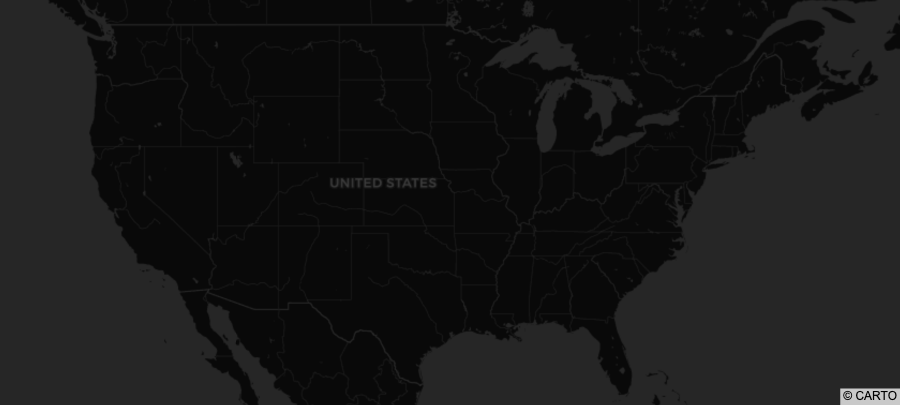

In [54]:
mapping(comp_df[comp_df.missing.isin(['No switchgrass', 'Neither'])],
        'CoA_tot_pct', 'Oranges', 'CoA active annual<br>cropland area<br>(%)', descrip='_SWG_missing',
       kwargs={"range_color": [0, 100]})

# Code fragments

In [55]:
def soil_stats(mukey):

    soil_cols = ['upper_depth_cm', 'lower_depth_cm', 'BD_g_cm3', 'FC', 'WP', 'evap_coef', 'frac_roots', 'sand', 'clay', 'OM',
                    'SWCmin', 'ksat_cm_s', 'pH']
    soils_path = '/Users/53f/Desktop/Local_datasets/IA_soils/'
    
    # read soils data, and create a dictionary for storing soil property calculation results
    soil_dir = str(mukey)[:-3]
    soil_fpath = os.path.join(soils_path, soil_dir, "{}.in".format(mukey))
    soil_df = pd.read_csv(soil_fpath, names=soil_cols, delimiter='\t')
    properties = {}

    # compute individual layer properties
    soil_df['WHC_cm'] = (soil_df.FC - soil_df.WP) * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
    soil_df['sand_cm'] = soil_df.sand * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)
    soil_df['clay_cm'] = soil_df.clay * (soil_df.lower_depth_cm - soil_df.upper_depth_cm)

    # extract & record individual properties of interset
    properties['mukey'] = mukey
    
    properties['WHC_cm'] = soil_df.WHC_cm.sum()
    properties['ksat_surf'] = soil_df.ksat_cm_s[0]
    properties['ksat_min'] = soil_df.ksat_cm_s.min()

    properties['sand_surf'] = soil_df.sand[0]
    properties['clay_surf'] = soil_df.clay[0]

    last_i = soil_df.index[-1]
    properties['sand_prof'] = soil_df.sand_cm.sum() / soil_df.lower_depth_cm[last_i]
    properties['clay_prof'] = soil_df.clay_cm.sum() / soil_df.lower_depth_cm[last_i]

    return properties

## Yield–soil comparison

In [56]:
# # subset & re-merge the data to calculate variety-driven differences in yield & dSOC
# cs_raw_df = cs_df[['fips', 'County', 'ST', 'strata_no', 'variety', 'time', 'NARR_year', 'annual_precip_cm', 'yield_Mg_ha', 'dSOC_MgC_ha']]
# cs_variety_df = cs_raw_df[cs_raw_df.variety == 'base']
# cs_drought_df = cs_raw_df[cs_raw_df.variety == 'drought_tol']
# cs_variety_df = pd.merge(cs_variety_df, cs_drought_df, on=['fips', 'County', 'ST', 'strata_no', 'time', 'NARR_year', 'annual_precip_cm'], 
#                          suffixes=('_base', '_drought_tol'))

# cs_variety_df['variety_yield_gain_Mg_ha'] = cs_variety_df.yield_Mg_ha_drought_tol - cs_variety_df.yield_Mg_ha_base
# cs_variety_df['variety_dSOC_gain_Mg_ha'] = cs_variety_df.dSOC_MgC_ha_drought_tol - cs_variety_df.dSOC_MgC_ha_base
# cs_variety_df.drop(columns=['variety_base', 'variety_drought_tol'], inplace=True)

# # re-associate w/ run_df to get soil & weather IDs for each strata
# cs_variety_df = pd.merge(cs_variety_df, run_df[['strata_no', 'mukey_int', 'gridx', 'gridy', 'latitude', 'peak_year']], on='strata_no')
# cs_variety_df

In [57]:
# # determine soils.in data that should be downloaded for further analysis

# # # count unique SSURGO map units in full case study dataset
# # mukeys = cs_variety_df.mukey_int.unique().tolist()
# # soil_dirs = [str(x)[:-3] for x in mukeys]
# # set(soil_dirs)

# # filter dataset down to a subset with common county, NARR grid, and peak year, to isolate soil effects
# cs_variety_df.value_counts(['fips', 'gridx', 'gridy', 'peak_year'])
# ##fips   gridx  gridy  peak_year
# ##19159  113    207    1970         2695
# cs_soils_df = cs_variety_df[(cs_variety_df.fips == 19159) & (cs_variety_df.gridx == 113) & (cs_variety_df.gridy == 207) & (cs_variety_df.peak_year == 1970)]
# unique_soils = cs_soils_df.mukey_int.unique()
# unique_soils

In [58]:
# # loop through case study subset mukeys, run soil property function, and store results in a nested list

# soil_data = [['mukey_int', 'WHC_cm', 'ksat_surf', 'ksat_min', 'sand_surf', 'clay_surf', 'sand_prof', 'clay_prof']]
# for mukey in unique_soils:
#     soil_props = soil_stats(mukey)
#     soil_data.append(list(soil_props.values()))

# # convert nested results list to a DataFrame, and merge with case study subset DataFrame
# soil_props_df = pd.DataFrame(soil_data[1:], columns=soil_data[0])
# soil_props_df

# cs_soils_df = pd.merge(cs_soils_df, soil_props_df, on='mukey_int', how='left')
# cs_soils_df

In [59]:
# ids = "_" + base_sims.split("_")[0] + "_" + drought_sims.split("_")[0]

# fig1, ax1 = plt.subplots()
# ax1 = cs_soils_df.plot.scatter(x='annual_precip_cm', y='yield_Mg_ha_base', c='WHC_cm', colormap='viridis', ax=ax1)
# fig1.savefig("Base_yield-vs-precip-by-WHC" + ids + ".pdf")

In [60]:
# fig2, ax2 = plt.subplots()
# ax2 = cs_soils_df.plot.scatter(x='WHC_cm', y='variety_yield_gain_Mg_ha', c='annual_precip_cm', colormap='viridis', ax=ax2)
# ax2.axhline(color='k')
# fig2.savefig("Yield_gain-vs-WHC-by-precip" + ids + ".pdf")

In [61]:
# ssurgo_metadata_fpath = '/Users/johnfield/Desktop/GCEP_local/ssurgo2012_texture_depth.csv'
# soil_df = pd.read_csv(ssurgo_metadata_fpath)

# cs_soil_df = pd.merge(cs_soil_df[['strata_no', 'time', 'yield_Mg_ha']],
#                       run_df[['strata_no', 'mukey_int', 'peak_year']],
#                       on='strata_no')
# cs_soil_df = pd.merge(cs_soil_df, soil_df, left_on='mukey_int', right_on='mukey')

# cs_soil_df['peak_year'].value_counts()
# # cs_soil_df.hist(column='peak_year')

# cs_soil_df.plot.scatter(x='depth', y='yield_Mg_ha')

## Climate analysis
Here's some initial exploratory code to parse a DayCent-format weather file and analyze inter-annual variability in growing-season temperatures and precipitation.

In [62]:
# weather_file1 = "NARR_89_234.wth"
# weather_df1 = pd.read_csv(weather_file1, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_file2 = "NARR_89_231.wth"
# weather_df2 = pd.read_csv(weather_file2, sep='\t', usecols=range(1, 7),
#                          names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
# weather_df2

In [63]:
# wth_df = pd.merge(weather_df1, weather_df2, on=['Month', 'Year', 'DayOfYear'], suffixes=['_234', '_231'])
# seasonal_wth_df = wth_df[wth_df['Month'].isin([5, 6, 7, 8, 9])]
# seasonal_wth_df['Tavg_C_231'] = (seasonal_wth_df['Tmin_C_231'] + seasonal_wth_df['Tmax_C_231']) / 2.0
# seasonal_wth_df['Tavg_C_234'] = (seasonal_wth_df['Tmin_C_234'] + seasonal_wth_df['Tmax_C_234']) / 2.0
# annunal_wth_df = seasonal_wth_df.groupby('Year').agg({'Tmax_C_231': 'mean',
#                                                       'Tavg_C_231': 'mean',
#                                                       'Precip_cm_231': 'sum',
#                                                       'Tmax_C_234': 'mean',
#                                                       'Tavg_C_234': 'mean',
#                                                       'Precip_cm_234': 'sum'})
# annunal_wth_df['Precip_diff_cm'] = annunal_wth_df['Precip_cm_231'] - annunal_wth_df['Precip_cm_234']
# annunal_wth_df.head()

In [64]:
# fig = plt.figure()
# spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 2])
# fig.suptitle("Difference between two weather grid centroids, 100km apart")

# ax0 = fig.add_subplot(spec[0])
# ax0.bar(annunal_wth_df.index, annunal_wth_df.Precip_diff_cm)
# plt.setp(ax0.get_xticklabels(), visible=False)
# plt.ylabel("Difference (cm)")

# ax1 = fig.add_subplot(spec[1], sharex=ax0)
# ax1.plot(annunal_wth_df.Precip_cm_231)
# ax1.plot(annunal_wth_df.Precip_cm_234)
# plt.xlabel("Year")
# plt.ylabel("May–Sept. total precip (cm)")

In [65]:
# plt.scatter(annunal_wth_df.Tavg_C_231, annunal_wth_df.Precip_cm_231)
# plt.title("Inter-annual variability in growing season weather")
# plt.xlabel("May–Sept. average air temperature (C)")
# plt.ylabel("May–Sept. total precipitation (cm)")